In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import scipy as sp
import scipy.optimize
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
import pdb
import h5py
import subprocess
import datetime
import pandas as pd

import platform
if platform.system() == 'Darwin':
    # On a Mac: usetex ok
    mpl.rc('font',**{'family':'serif','serif':['Computer Modern']})
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=True)
elif platform.node().startswith("D"):
    # On hyak: usetex not ok, must change backend to 'agg'
    mpl.rc('font',**{'family':'serif','serif':['Computer Modern']})
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=False)
    plt.switch_backend('agg')
else:
    # On astro machine or other linux: usetex not ok
    plt.switch_backend('agg')
    mpl.rc('font', family='Times New Roman')
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=False)

/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/linalg/__init__.py:202: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._decomp_update import *
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/optimize/_trlib/__init__.py:1: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._trlib import TRLIBQuadraticSubproblem
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/sparse/lil.py:16: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/special/__init__.py:640: RuntimeWarning: numpy.dtype size changed, may indicate bi

In [2]:
import smart
import coronagraph as cg
import pandas as pd

/Users/Jake/Projects/Packages/photochem_smart/smart/extra/gas_info.py:67: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  'mass', 'minwn', 'maxwn', 'n'])
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/interpolate/_bsplines.py:9: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _bspl
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/spatial/__init__.py:94: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .ckdtree import *
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/spatial/__init__.py:95: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .qhull import *
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/spatial/_spherical_voronoi.py:18: RuntimeWarning: numpy.dtype size 

In [3]:
sys.path.insert(1, "../scripts")

import spectroscopy

In [4]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 200
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

Text(0,0.5,'Reflectivity')

/Users/Jake/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1339: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


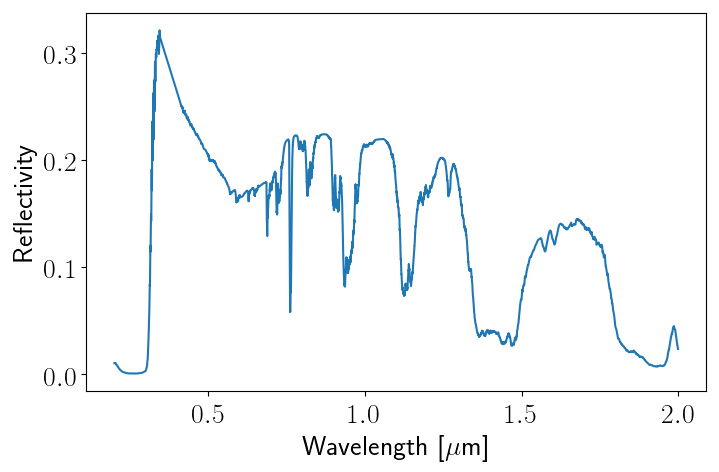

In [5]:
lamhr, Ahr, fstar = cg.get_earth_reflect_spectrum()

lammin = 0.2
lammax = 2.0
m = (lamhr > lammin) & (lamhr < lammax)

plt.plot(lamhr[m], Ahr[m])
plt.xlabel("Wavelength [$\mu$m]")
plt.ylabel("Reflectivity")

In [6]:
# Create generic coronagraph noise object
cn = cg.CoronagraphNoise()

/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


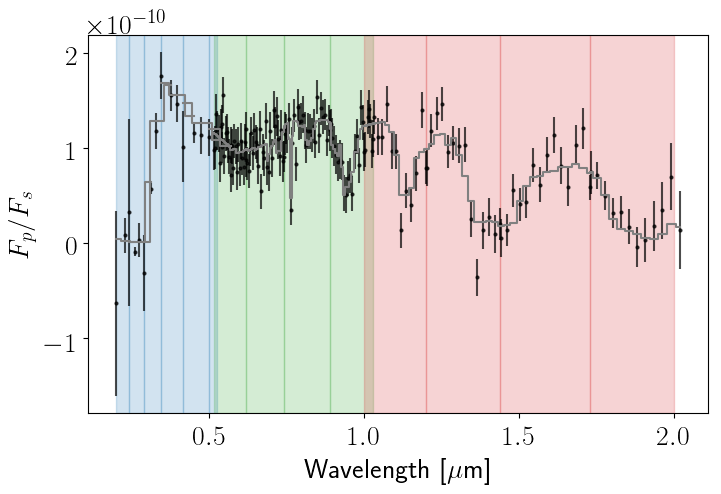

In [7]:
t_tot, tpbpc, spectrum, iwa = spectroscopy.complete_spectrum_time(cn, plot=True)

In [8]:
t_tot

14057.483377186905

In [9]:
biased_sample = spectroscopy.read_luvoir_stars()
biased_sample.keys()

[u'hip', u'dist', u'stype']

In [10]:
NBIAS = len(biased_sample["dist"])

In [11]:
wantSNR = 10.0

# Perform calculation for all stars in biased sample
biased_sample = spectroscopy.read_luvoir_stars()
Ndraw = len(biased_sample["dist"])

np.random.seed(seed=None)

# Allocate memory for exposure times
t_tots = np.zeros(Ndraw)
tpbpcs = []
pct_obs_iwas = []
lammax_obs_iwas = []
specs = []

# Loop over stars in this sample
for i in range(Ndraw):
    #print("HIP %i, %.2f pc, %s " %(hip[i], dist[i], stype[i]))

    # Set system parameters for this star
    cn = spectroscopy.prep_ith_star(cn, i)
    
    # Calculate the time to observe the complete spectrum
    t_tots[i], tpbpc, spectrum, iwa = spectroscopy.complete_spectrum_time(cn, plot=False) 
    
    tpbpcs.append(tpbpc)
    pct_obs_iwas.append(iwa[0])
    specs.append(spectrum)

/Users/Jake/Projects/coronagraph/coronagraph/count_rates.py:288: RuntimeWarning: divide by zero encountered in true_divide
  Csig = self.Cratio/SNRt
/Users/Jake/Projects/coronagraph/coronagraph/count_rates.py:289: RuntimeWarning: divide by zero encountered in true_divide
  Asig = self.A/SNRt
../scripts/spectroscopy.py:328: RuntimeWarning: divide by zero encountered in double_scalars
  t_snr = (wantsnr**2 - intercept) / slope
/Users/Jake/Projects/coronagraph/coronagraph/count_rates.py:285: RuntimeWarning: invalid value encountered in multiply
  SNRt  = self.cp * Dt / np.sqrt((self.cp + roll_factor*self.cb) * Dt)
/Users/Jake/Projects/coronagraph/coronagraph/count_rates.py:285: RuntimeWarning: invalid value encountered in true_divide
  SNRt  = self.cp * Dt / np.sqrt((self.cp + roll_factor*self.cb) * Dt)


In [12]:
# Calculate channel widths
deltas = []
for channel in spectroscopy.CHANNELS:
    l = spectroscopy.default_luvoir(channel=channel)
    deltas.append(l.lammax - l.lammin)
deltas = np.array(deltas)

channel_weights = (deltas / np.sum(deltas))

completeness = np.sum(np.array(pct_obs_iwas) * channel_weights, axis = 1)

Text(0,0.5,'Total Exposure Time [hrs]')

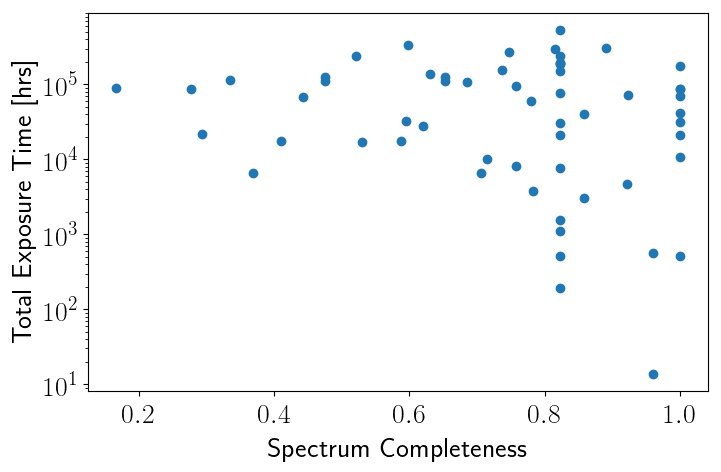

In [13]:
plt.plot(completeness, t_tots, "o")
plt.yscale("log")
plt.xlabel("Spectrum Completeness")
plt.ylabel("Total Exposure Time [hrs]")

In [14]:
# Max Number of channels to remove
N = 3

tpbpcs_N = [tpbpcs]
modcomps_N = np.zeros((N+1, NBIAS))
completeness_N = np.zeros((N+1, NBIAS))
t_tots_N = np.zeros((N+1, NBIAS))

modcomps_N[0,:]
completeness_N[0,:] = completeness
t_tots_N[0,:] = t_tots

for i in range(N):
    tmpt = []
    tmpc = []
    for j in range(NBIAS):
        new_tpbpc, modtime, modcomp, maxderiv = spectroscopy.remove_worst_bandpass(tpbpcs_N[-1][j], specs[j])
        tmpt.append(new_tpbpc)
        modcomps_N[i+1,j] = modcomp
        completeness_N[i+1,j] = completeness[j] - np.sum(modcomps_N[:,j])
        t_tots_N[i+1,j] = spectroscopy.apply_two_channels(spectroscopy.calc_t_chan(new_tpbpc))
    tpbpcs_N.append(tmpt)

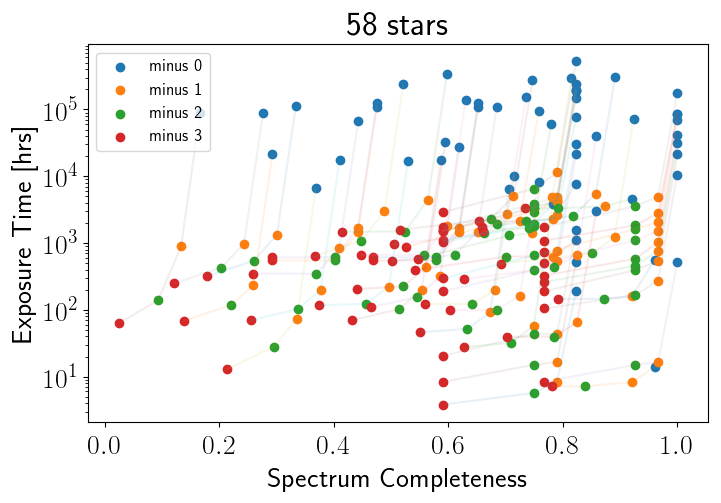

In [15]:
fig, ax = plt.subplots()

for i in range(N+1):
    s = ax.scatter(completeness_N[i,:], t_tots_N[i,:], marker = "o", label = "minus %i" %(i))

for i in range(NBIAS):
    ax.plot(completeness_N[:,i], t_tots_N[:,i], alpha = 0.1)
    
ax.set_yscale("log")
ax.set_title("%i stars" %NBIAS)
#plt.colorbar(s, label = clabel)
ax.set_xlabel("Spectrum Completeness")
ax.set_ylabel("Exposure Time [hrs]")
ax.legend(fontsize = 12)

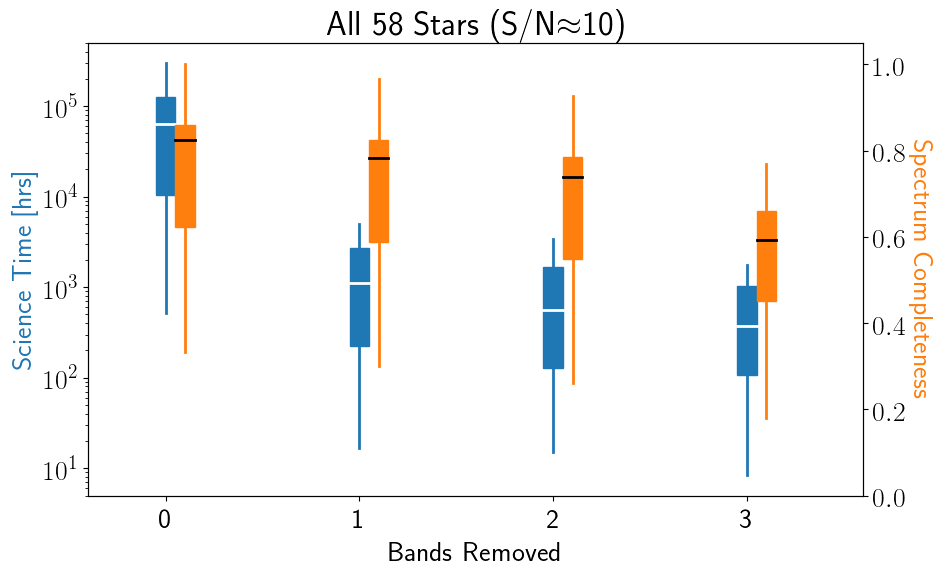

In [16]:
fig2, ax2 = plt.subplots(figsize = (10,6))
ax3 = ax2.twinx()
    
data = [t_tots_N[i,:] for i in range(N+1)]
color1 = "C0"
positions = np.arange(N+1)
bp1 = ax2.boxplot(data, sym = '', widths = 0.1, showfliers = False, boxprops = {"color" :color1}, 
                 whiskerprops = {"color" : color1, "linewidth" : 2.0}, capprops = {"color" : color1, "linewidth" : 0.0}, medianprops = {"color" : "w", "linewidth" : 2.0}, 
                 patch_artist=True, positions = positions, whis = [5, 95]); 

data = [completeness_N[i,:] for i in range(N+1)]
color2 = "C1"
positions = np.arange(N+1) + 0.1
bp2 = ax3.boxplot(data, sym = '', widths = 0.1, showfliers = False, boxprops = {"color" : color2}, 
                 whiskerprops = {"color" : color2, "linewidth" : 2.0}, capprops = {"color" : color2, "linewidth" : 0.0}, medianprops = {"color" : "k", "linewidth" : 2.0}, 
                 patch_artist=True, positions = positions, whis = [5, 95]); 

for patch in bp1['boxes']:
    patch.set_facecolor(color1)
for patch in bp2['boxes']:
    patch.set_facecolor(color2)
    
ax2.set_ylabel("Science Time [hrs]", color = color1)
ax2.set_title(r"All %i Stars (S/N$\approx$%i)" %(NBIAS, wantSNR))
ax2.set_yscale("log")

ax2.set_xlabel("Bands Removed")
ax3.set_ylabel("Spectrum Completeness", rotation = 270, labelpad = 22, color = color2)
ax3.set_ylim(0.0,1.05)

ax2.set_xticks(np.arange(N+1));
ax2.set_xticklabels(np.arange(N+1));

/Users/Jake/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:3238: RuntimeWarning: invalid value encountered in double_scalars
  in cbook.safezip(data, err)]
/Users/Jake/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/__init__.py:1792: RuntimeWarning: invalid value encountered in double_scalars
  notch_min = med - 1.57 * iqr / np.sqrt(N)


(0.1, 2.0)

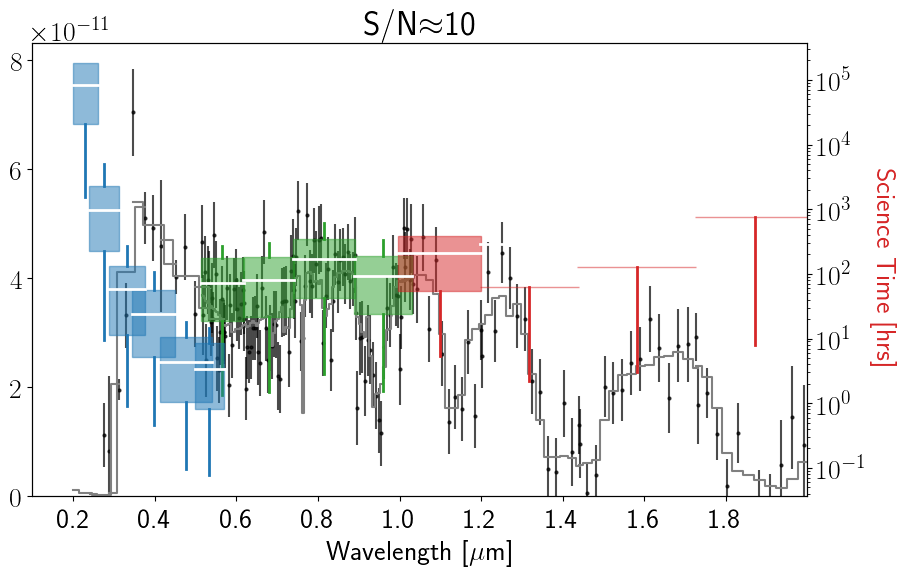

In [17]:
fig, ax = plt.subplots(figsize = (10,6))
cc = ["C0", "C2", "C3"]

ax2 = ax.twinx()

#ax.plot(lamhr, Ahr, c = "k", zorder = 100)
#ax.set_ylim(0.0, 0.1*np.ceil(10*np.max(Ahr[lamhr < 2.0])))
#ax.set_ylabel("Geometric Albedo")

tmp = [np.zeros((len(tpbpcs[0][i]), len(tpbpcs))) for i in range(len(tpbpcs[0]))]
for i in range(len(tpbpcs)):
    for j in range(len(tpbpcs[0])):
        tmp[j][:,i] = tpbpcs[i][j]

icount = 0
for j in range(len(tmp)):
    
    data = []
    positions = []
    widths = []
    for i in range(tmp[j].shape[0]):
        data.append(tmp[j][i,:])
        positions.append(np.mean(specs[0][0][icount]))
        widths.append(specs[0][0][icount][-1] - specs[0][0][icount][0])
        
        ax.plot(specs[0][0][icount], specs[0][1][icount], ls = "steps-mid", color = "grey", zorder = 100)
        ax.errorbar(specs[0][0][icount], specs[0][2][icount], yerr=specs[0][3][icount], fmt = "o", ms = 2.0, alpha = 0.7, color = "k")
        
        icount += 1
        
    color1 = cc[j]
    positions = np.array(positions)
    widths = np.array(widths)
    bp1 = ax2.boxplot(data, sym = '', widths = widths, showfliers = False, 
                      boxprops = {"color" : color1, "alpha" : 0.5}, 
                      whiskerprops = {"color" : color1, "linewidth" : 2.0}, 
                      capprops = {"color" : color1, "linewidth" : 0.0}, 
                      medianprops = {"color" : "w", "linewidth" : 2.0}, 
                      patch_artist=True, positions = positions, whis = [5, 95]); 

    for patch in bp1['boxes']:
        patch.set_facecolor(color1)
    
ax2.set_ylabel("Science Time [hrs]", color = color1, rotation = 270, labelpad = 22)
ax2.set_title(r"S/N$\approx$%i" %wantSNR)
ax2.set_yscale("log")

ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylim(bottom = 0.0)

ax2.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8])
ax2.set_xticklabels([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8])
ax2.set_xlim(0.1, 2.0)

In [18]:
Xdraw = 500    # Number for unbiased random samples
Ndraw = 5      # Number of stars to randomly draw from biased sample
Nrem = 1

np.random.seed(seed=None)

# Get index with matching stellar type in stellar properties table
imatches = np.array([spectroscopy.match_stellar_type(biased_sample["stype"][j], verbose = False) for j in range(NBIAS)])

# Allocate memory for exposure times
ctime_tot = np.zeros((Ndraw, Xdraw))
ccomp_tot = np.zeros((Ndraw, Xdraw))

# Loop over number of random draws (for bootstrapping distributions)
for ix in range(Xdraw):
    
    # Randomly draw sample indices
    idraw = np.random.choice(np.arange(NBIAS), size=Ndraw, replace=False)
    
    # Order systems by "detectability" (sorting must happen at a later step)
    #idraw = idraw[np.argsort(dist[idraw])]   # Simply distance for now
    
    # Get the total exposure time and completeness for the selected stars
    ctime_tmp = t_tots_N[Nrem, idraw]
    ccomp_tmp = completeness_N[Nrem, idraw]
    
    # Sort by exposure time (to break a labeling degeneracy and express uniqueness and priority)
    isort = np.argsort(ctime_tmp)
    
    # Set exposure time for this star
    ctime_tot[:, ix] = ctime_tmp[isort]

    # Set completeness for this star
    ccomp_tot[:, ix] = ccomp_tmp[isort]

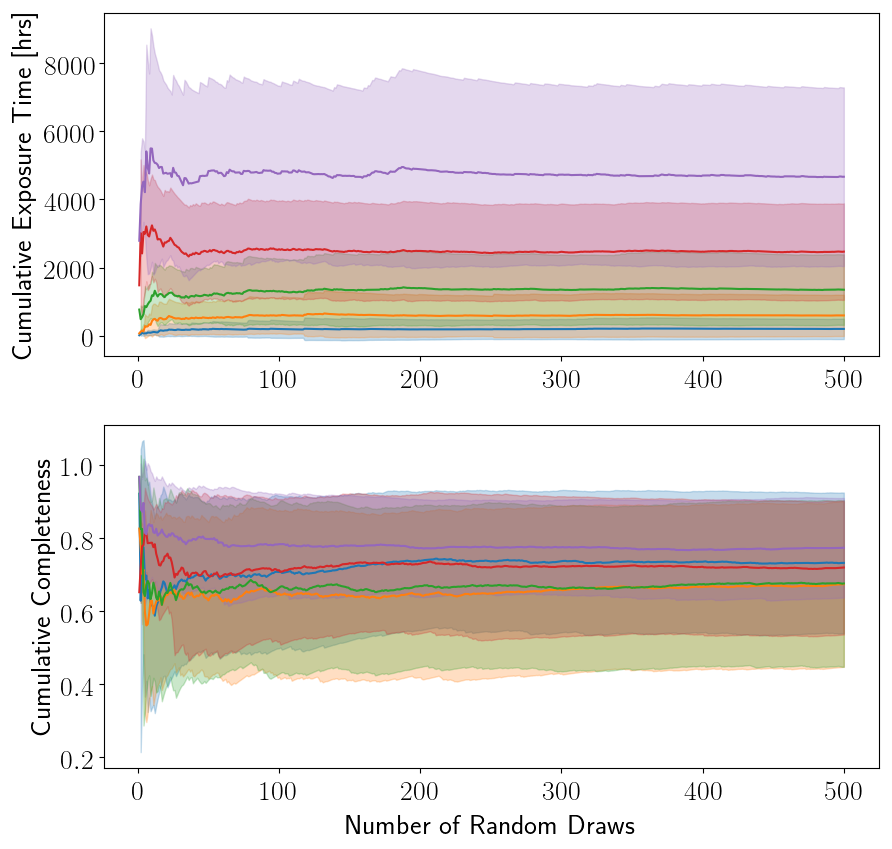

In [19]:
fig, ax = plt.subplots(2, 1, figsize = (10,10))

# Loop over stars in sample
for i in range(Ndraw):
    
    # Calculate the cumulative mean time (to estimate convergence)
    cummean_time = pd.Series(ctime_tot[i,:]).expanding(1).mean().values
    # Calculate the cumulative std deviation 
    cumstd_time = pd.Series(ctime_tot[i,:]).expanding(1).std().values
    
    # Calculate the cumulative mean completeness (to estimate convergence)
    cummean_comp = pd.Series(ccomp_tot[i,:]).expanding(1).mean().values
    # Calculate the cumulative std deviation 
    cumstd_comp = pd.Series(ccomp_tot[i,:]).expanding(1).std().values
    
    # Plot time
    ax[0].plot((np.arange(Xdraw)+1), cummean_time, c = "C%i" %(i%9))
    #ax.errorbar(np.arange(Xdraw)+1, cummean, yerr=cumstd)
    ax[0].fill_between(np.arange(Xdraw)+1, cummean_time - cumstd_time, cummean_time + cumstd_time, alpha = 0.25, color = "C%i" %(i%9))
    ax[0].set_ylabel("Cumulative Exposure Time [hrs]")
    #ax[0].set_title("Full Spectrum")
    
     # Plot completeness
    ax[1].plot((np.arange(Xdraw)+1), cummean_comp, c = "C%i" %(i%9))
    #ax.errorbar(np.arange(Xdraw)+1, cummean, yerr=cumstd)
    ax[1].fill_between(np.arange(Xdraw)+1, cummean_comp - cumstd_comp, cummean_comp + cumstd_comp, alpha = 0.25, color = "C%i" %(i%9))
    ax[1].set_xlabel("Number of Random Draws")
    ax[1].set_ylabel("Cumulative Completeness")

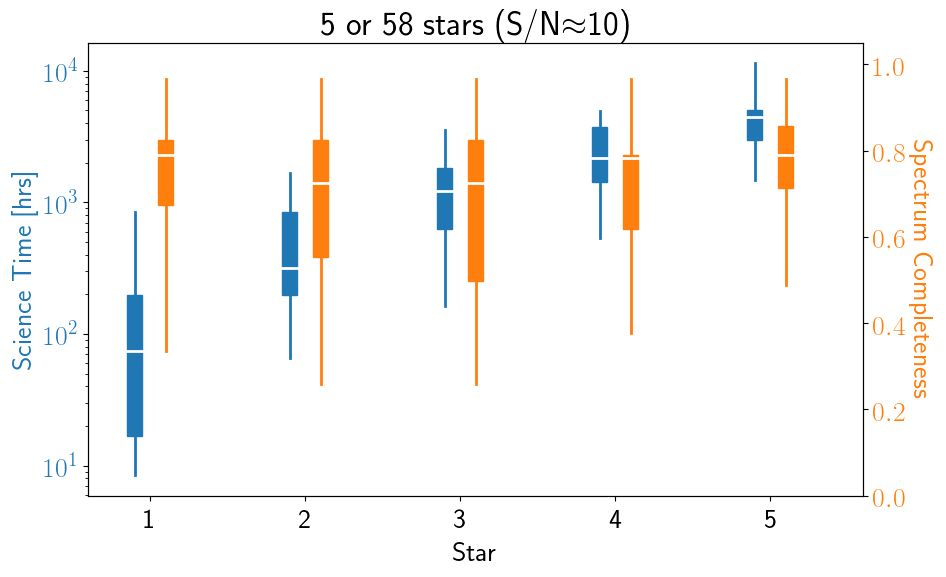

In [20]:
fig2, ax2 = plt.subplots(figsize = (10,6))
ax3 = ax2.twinx()

# Loop over stars in sample
for i in range(Ndraw):

    # Plot time intervals
    #q_l, q_50, q_h, q_m, q_p = nsig_intervals(ctime_tot[i,:], intvls=[0.16, 0.5, 0.84])
    #ax2.errorbar(i+1, q_50, yerr = np.array([q_m, q_p]).reshape((2,1)), fmt = "o", color = "C0")
    
    # Plot completeness intervals
    #q_l, q_50, q_h, q_m, q_p = nsig_intervals(ccomp_tot[i,:], intvls=[0.16, 0.5, 0.84])
    #ax3.errorbar(i+1.05, q_50, yerr = np.array([q_m, q_p]).reshape((2,1)), fmt = "x", color = "C1")
    #ax2[1].set_yscale("log")
    pass
    
data = [ctime_tot[i,:] for i in range(Ndraw)]
color1 = "C0"
positions = np.arange(Ndraw) + 0.9
bp1 = ax2.boxplot(data, sym = '', widths = 0.1, showfliers = False, boxprops = {"color" :color1}, 
                 whiskerprops = {"color" : color1, "linewidth" : 2.0}, capprops = {"color" : color1, "linewidth" : 0.0}, medianprops = {"color" : "w", "linewidth" : 2.0}, 
                 patch_artist=True, positions = positions, whis = [5, 95]); 

data = [ccomp_tot[i,:] for i in range(Ndraw)]
color2 = "C1"
positions = np.arange(Ndraw) + 1.1
bp2 = ax3.boxplot(data, sym = '', widths = 0.1, showfliers = False, boxprops = {"color" : color2}, 
                 whiskerprops = {"color" : color2, "linewidth" : 2.0}, capprops = {"color" : color2, "linewidth" : 0.0}, medianprops = {"color" : "w", "linewidth" : 2.0}, 
                 patch_artist=True, positions = positions, whis = [5, 95]); 

for patch in bp1['boxes']:
    patch.set_facecolor(color1)
for patch in bp2['boxes']:
    patch.set_facecolor(color2)
    
_ = [i.set_color(color1) for i in ax2.get_yticklabels()];
_ = [i.set_color(color2) for i in ax3.get_yticklabels()];
    
ax2.set_ylabel("Science Time [hrs]", color = color1)
ax2.set_title(r"%i or %i stars (S/N$\approx$%i)" %(Ndraw, NBIAS, wantSNR))
ax2.set_yscale("log")

ax2.set_xlabel("Star")
ax3.set_ylabel("Spectrum Completeness", rotation = 270, labelpad = 22, color = color2)
ax3.set_ylim(0.0,1.05)

ax2.set_xticks(np.arange(Ndraw)+1);
ax2.set_xticklabels(np.arange(Ndraw)+1);

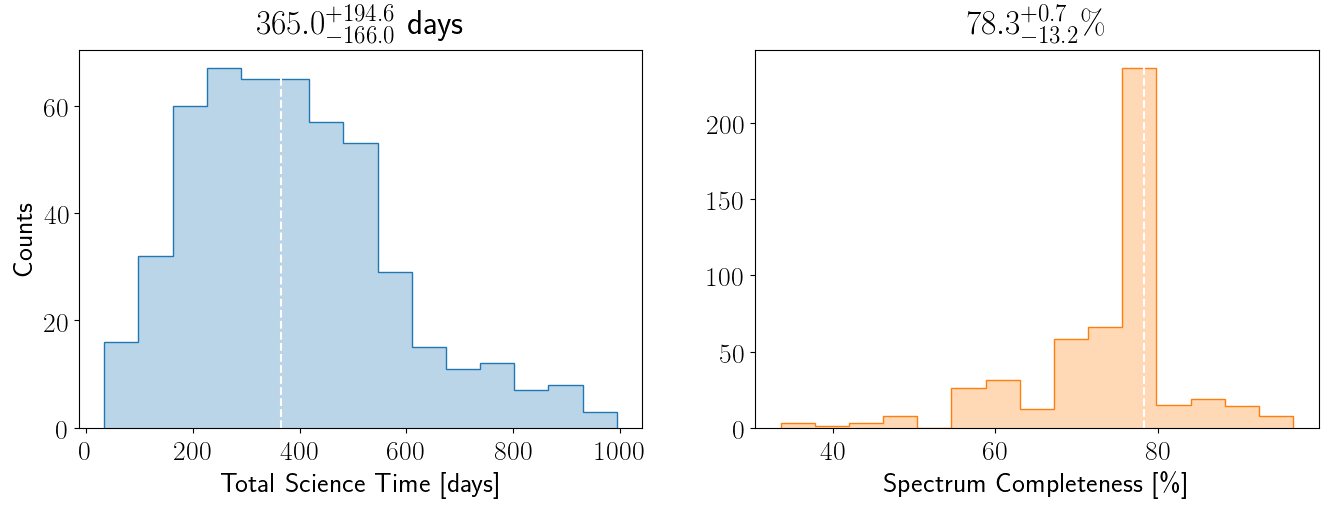

In [21]:
fig4, ax4 = plt.subplots(1, 2, figsize = (16,5))

ctime_sum = np.sum(ctime_tot, axis = 0) / 24.
ctime_med = np.median(ctime_sum)
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(ctime_sum)
result = "$%.1f^{+%.1f}_{-%.1f}$ days" %(q_50, q_p, q_m)

ax4[0].set_xlabel("Total Science Time [days]")
ax4[0].set_ylabel("Counts")
ax4[0].set_title(result)
ax4[0].hist(ctime_sum, bins = 15, alpha = .3, color = "C0");
ax4[0].hist(ctime_sum, bins = 15, alpha = 1.0, histtype="step", color = "C0");
ax4[0].axvline(ctime_med, color = "w", ls = "dashed")

ccomp_meds = np.median(ccomp_tot, axis = 0) * 100.
ccomp_med = np.median(ccomp_meds)
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(ccomp_meds)
result = "$%.1f^{+%.1f}_{-%.1f} \%%$ " %(q_50, q_p, q_m)

ax4[1].set_xlabel("Spectrum Completeness [\%]")
ax4[1].set_title(result)
ax4[1].hist(ccomp_meds, bins = 15, alpha = .3, color = "C1");
ax4[1].hist(ccomp_meds, bins = 15, alpha = 1.0, histtype="step", color = "C1");
ax4[1].axvline(ccomp_med, color = "w", ls = "dashed")

In [22]:
def sample_complete_spectra(t_tots_N, completeness_N, Ndraw = 5, Xdraw = 500, Nrem = 0, 
                            plot_converge = False, plot_stats = True, plot_totals = True):
    """
    """
    
    #Xdraw = 500    # Number for unbiased random samples
    #Ndraw = 5      # Number of stars to randomly draw from biased sample
    #Nrem = 1
    
    """
    Randomly sample ``Ndraw`` stars ``Xdraw`` number of times
    """

    # Get index with matching stellar type in stellar properties table
    imatches = np.array([spectroscopy.match_stellar_type(biased_sample["stype"][j], verbose = False) for j in range(NBIAS)])

    # Allocate memory for exposure times
    ctime_tot = np.zeros((Ndraw, Xdraw))
    ccomp_tot = np.zeros((Ndraw, Xdraw))

    # Loop over number of random draws (for bootstrapping distributions)
    for ix in range(Xdraw):

        # Randomly draw sample indices
        idraw = np.random.choice(np.arange(NBIAS), size=Ndraw, replace=False)

        # Order systems by "detectability" (sorting must happen at a later step)
        #idraw = idraw[np.argsort(dist[idraw])]   # Simply distance for now

        # Get the total exposure time and completeness for the selected stars
        ctime_tmp = t_tots_N[Nrem, idraw]
        ccomp_tmp = completeness_N[Nrem, idraw]

        # Sort by exposure time (to break a labeling degeneracy and express uniqueness and priority)
        isort = np.argsort(ctime_tmp)

        # Set exposure time for this star
        ctime_tot[:, ix] = ctime_tmp[isort]

        # Set completeness for this star
        ccomp_tot[:, ix] = ccomp_tmp[isort]
        
    """
    Plot cumulative stats to test for stability
    """
    
    if plot_converge:
    
        fig, ax = plt.subplots(2, 1, figsize = (10,10))

        # Loop over stars in sample
        for i in range(Ndraw):

            # Calculate the cumulative mean time (to estimate convergence)
            cummean_time = pd.Series(ctime_tot[i,:]).expanding(1).mean().values
            # Calculate the cumulative std deviation 
            cumstd_time = pd.Series(ctime_tot[i,:]).expanding(1).std().values

            # Calculate the cumulative mean completeness (to estimate convergence)
            cummean_comp = pd.Series(ccomp_tot[i,:]).expanding(1).mean().values
            # Calculate the cumulative std deviation 
            cumstd_comp = pd.Series(ccomp_tot[i,:]).expanding(1).std().values

            # Plot time
            ax[0].plot((np.arange(Xdraw)+1), cummean_time, c = "C%i" %(i%9))
            #ax.errorbar(np.arange(Xdraw)+1, cummean, yerr=cumstd)
            ax[0].fill_between(np.arange(Xdraw)+1, cummean_time - cumstd_time, cummean_time + cumstd_time, alpha = 0.25, color = "C%i" %(i%9))
            ax[0].set_ylabel("Cumulative Exposure Time [hrs]")
            #ax[0].set_title("Full Spectrum")

             # Plot completeness
            ax[1].plot((np.arange(Xdraw)+1), cummean_comp, c = "C%i" %(i%9))
            #ax.errorbar(np.arange(Xdraw)+1, cummean, yerr=cumstd)
            ax[1].fill_between(np.arange(Xdraw)+1, cummean_comp - cumstd_comp, cummean_comp + cumstd_comp, alpha = 0.25, color = "C%i" %(i%9))
            ax[1].set_xlabel("Number of Random Draws")
            ax[1].set_ylabel("Cumulative Completeness")
            
    
    """
    Plot statistics
    """
    if plot_stats:
    
        fig2, ax2 = plt.subplots(figsize = (10,6))
        ax3 = ax2.twinx()

        data = [ctime_tot[i,:] for i in range(Ndraw)]
        color1 = "C0"
        positions = np.arange(Ndraw) + 0.9
        bp1 = ax2.boxplot(data, sym = '', widths = 0.1, showfliers = False, boxprops = {"color" :color1}, 
                         whiskerprops = {"color" : color1, "linewidth" : 2.0}, capprops = {"color" : color1, "linewidth" : 0.0}, medianprops = {"color" : "w", "linewidth" : 2.0}, 
                         patch_artist=True, positions = positions, whis = [5, 95]); 

        data = [ccomp_tot[i,:] for i in range(Ndraw)]
        color2 = "C1"
        positions = np.arange(Ndraw) + 1.1
        bp2 = ax3.boxplot(data, sym = '', widths = 0.1, showfliers = False, boxprops = {"color" : color2}, 
                         whiskerprops = {"color" : color2, "linewidth" : 2.0}, capprops = {"color" : color2, "linewidth" : 0.0}, medianprops = {"color" : "w", "linewidth" : 2.0}, 
                         patch_artist=True, positions = positions, whis = [5, 95]); 

        for patch in bp1['boxes']:
            patch.set_facecolor(color1)
        for patch in bp2['boxes']:
            patch.set_facecolor(color2)

        _ = [i.set_color(color1) for i in ax2.get_yticklabels()];
        _ = [i.set_color(color2) for i in ax3.get_yticklabels()];

        ax2.set_ylabel("Science Time [hrs]", color = color1)
        ax2.set_title(r"%i or %i stars (S/N$\approx$%i)" %(Ndraw, NBIAS, wantSNR))
        ax2.set_yscale("log")

        ax2.set_xlabel("Star")
        ax3.set_ylabel("Spectrum Completeness", rotation = 270, labelpad = 22, color = color2)
        ax3.set_ylim(0.0,1.05)
        
        ax2.set_xticks(np.arange(Ndraw)+1);
        ax2.set_xticklabels(np.arange(Ndraw)+1);
        
    if plot_totals:
        
        fig4, ax4 = plt.subplots(1, 2, figsize = (16,5))

        # Plot exposure time hist
        ctime_sum = np.sum(ctime_tot, axis = 0) / 24.
        ctime_med = np.median(ctime_sum)
        q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(ctime_sum)
        result = "$%.1f^{+%.1f}_{-%.1f}$ days" %(q_50, q_p, q_m)
        ax4[0].set_xlabel("Total Science Time [days]")
        ax4[0].set_ylabel("Counts")
        ax4[0].set_title(result)
        ax4[0].hist(ctime_sum, bins = 15, alpha = .3, color = "C0");
        ax4[0].hist(ctime_sum, bins = 15, alpha = 1.0, histtype="step", color = "C0");
        ax4[0].axvline(ctime_med, color = "w", ls = "dashed")

        # Plot completeness hist
        ccomp_meds = np.median(ccomp_tot, axis = 0) * 100.
        ccomp_med = np.median(ccomp_meds)
        q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(ccomp_meds)
        result = "$%.1f^{+%.1f}_{-%.1f} \%%$ " %(q_50, q_p, q_m)
        ax4[1].set_xlabel("Spectrum Completeness [\%]")
        ax4[1].set_title(result)
        ax4[1].hist(ccomp_meds, bins = 15, alpha = .3, color = "C1");
        ax4[1].hist(ccomp_meds, bins = 15, alpha = 1.0, histtype="step", color = "C1");
        ax4[1].axvline(ccomp_med, color = "w", ls = "dashed")
    
    return 

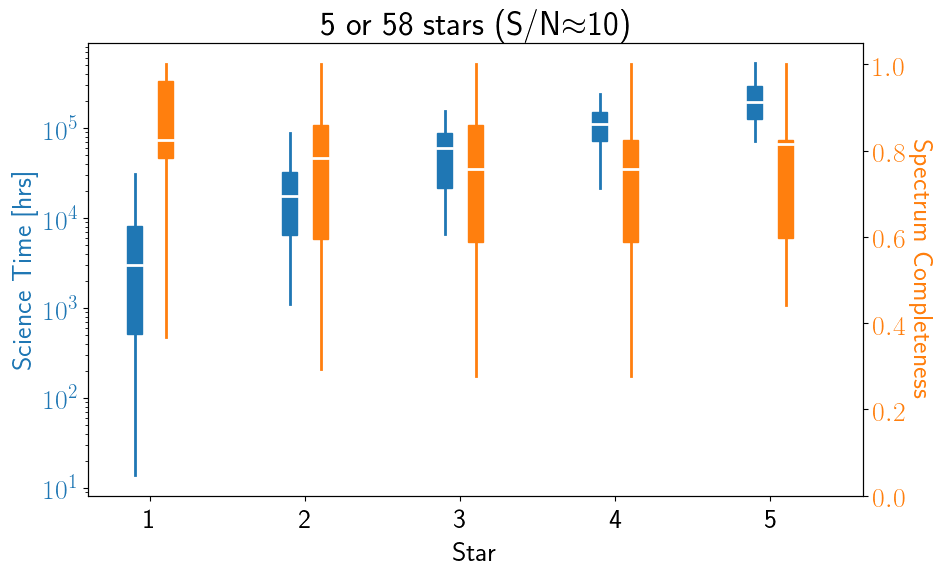

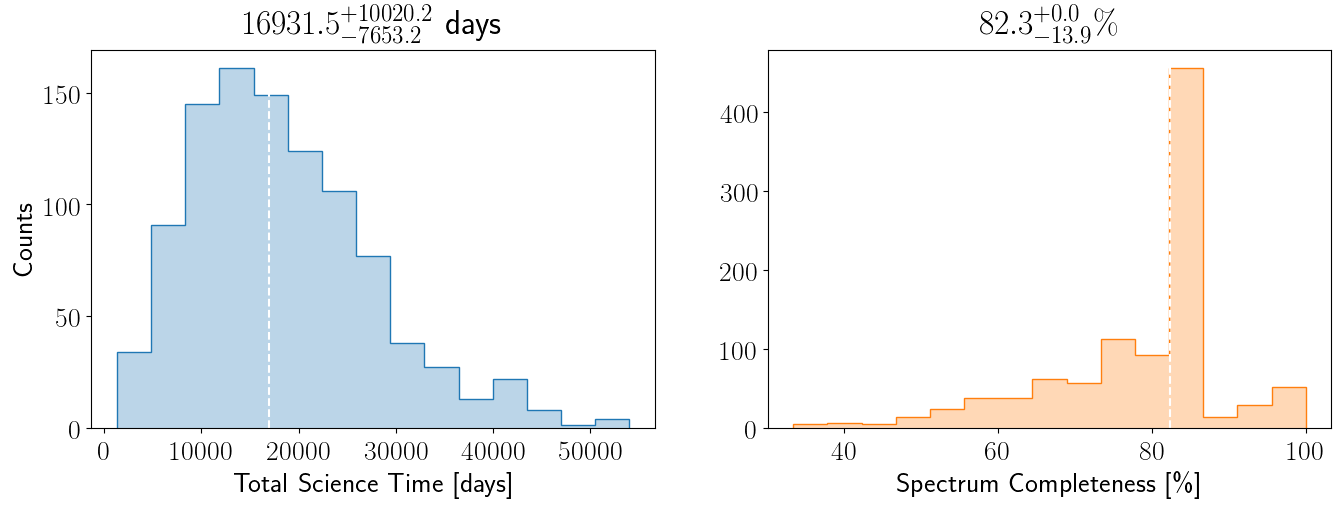

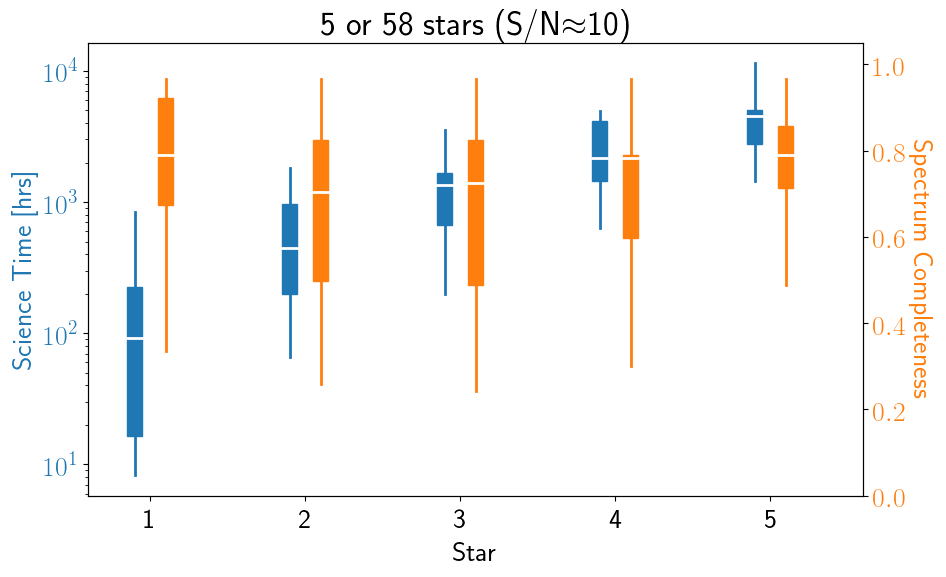

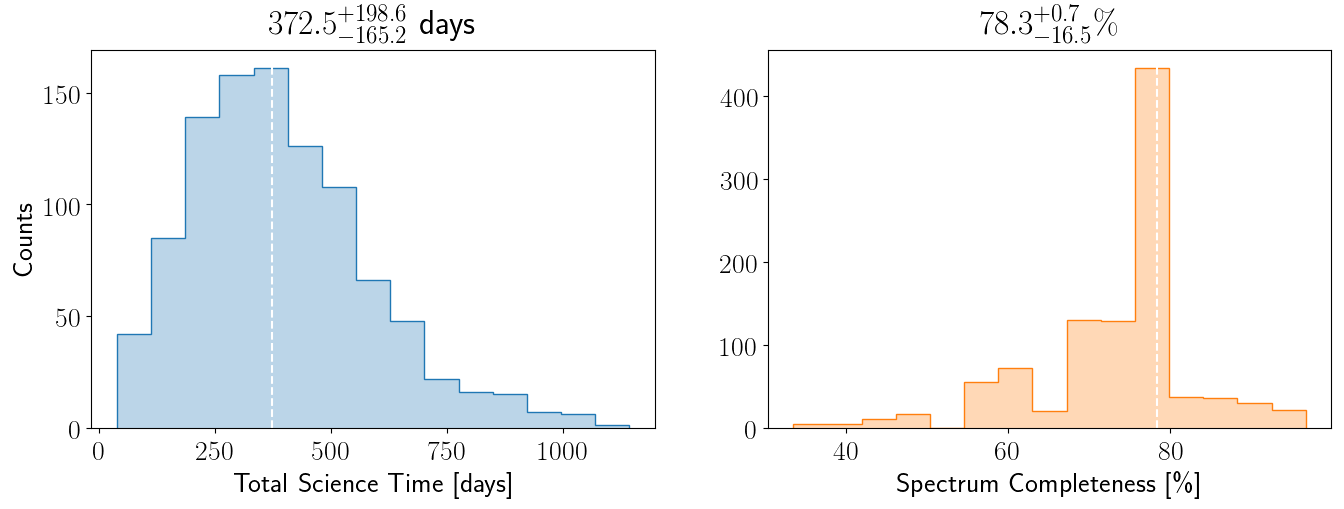

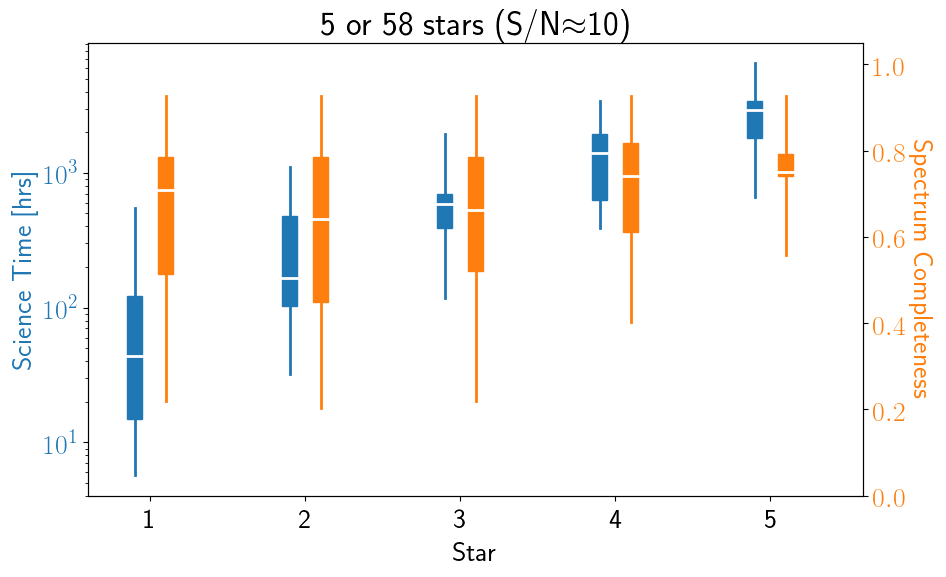

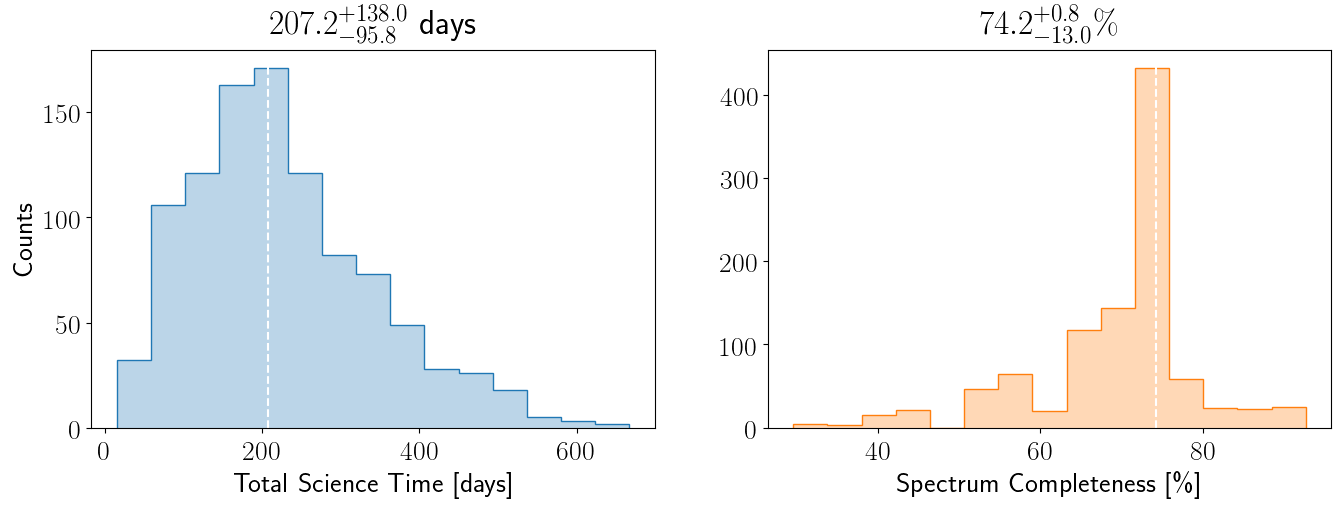

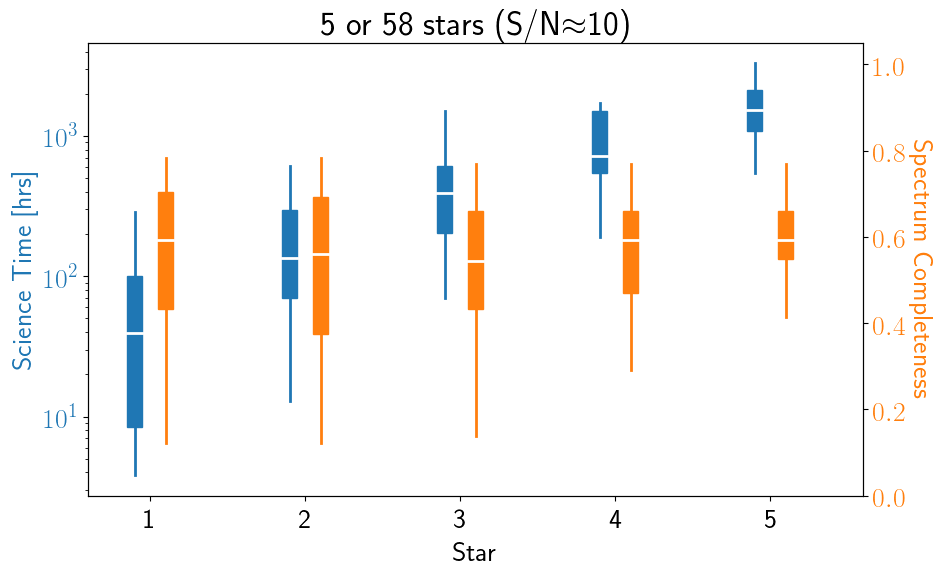

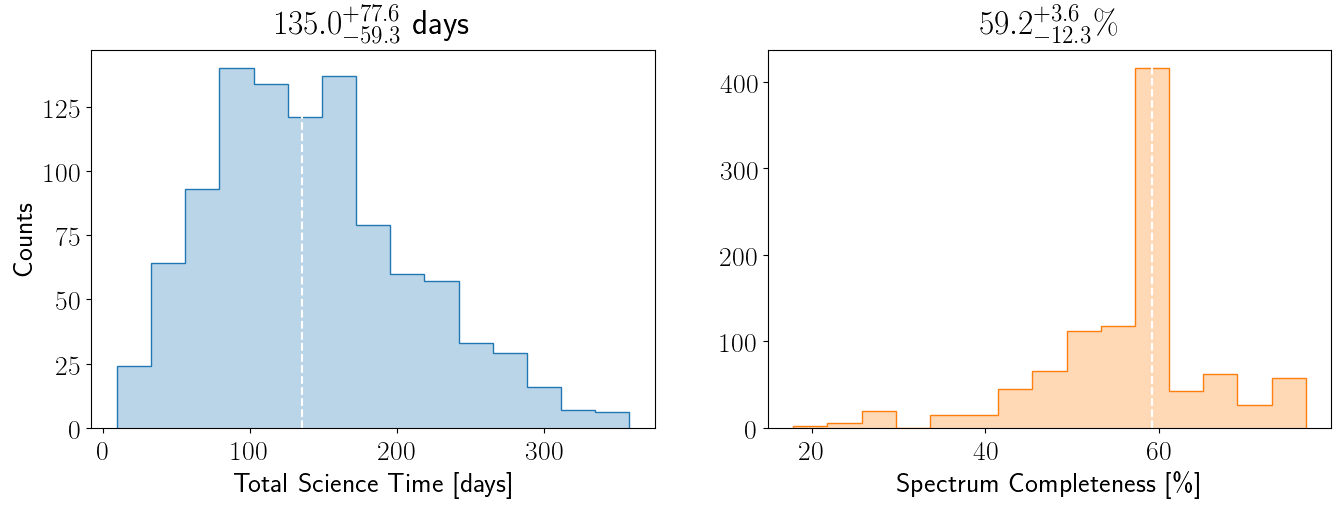

In [23]:
np.random.seed(seed=None)
Xdraw = 1000
Ndraw = 5     # of 58

sample_complete_spectra(t_tots_N, completeness_N, Ndraw = Ndraw, Xdraw = Xdraw, Nrem = 0, 
                        plot_converge = False, plot_stats = True)

sample_complete_spectra(t_tots_N, completeness_N, Ndraw = Ndraw, Xdraw = Xdraw, Nrem = 1, 
                        plot_converge = False, plot_stats = True)

sample_complete_spectra(t_tots_N, completeness_N, Ndraw = Ndraw, Xdraw = Xdraw, Nrem = 2, 
                        plot_converge = False, plot_stats = True)

sample_complete_spectra(t_tots_N, completeness_N, Ndraw = Ndraw, Xdraw = Xdraw, Nrem = 3, 
                        plot_converge = False, plot_stats = True)

# Calculate Randomly Sampled Exposure Times for Each Bandpass

In [24]:
tpbpcs_draws_stars = []
tpbpcs_draws_tots = []
comp_draws_stars = []

for ichan in range(len(spectroscopy.CHANNELS)):
    
    tpbpcs_draws_stars.append([])
    tpbpcs_draws_tots.append([])
    comp_draws_stars.append([])
        
    for iband in range(len(tpbpcs[0][ichan])):
                
        samples = np.zeros((Ndraw, Xdraw))
        for ix in range(Xdraw):
            
            # Randomly draw sample indices
            idraw = np.random.choice(np.arange(NBIAS), size=Ndraw, replace=False)
            
            # Get exptimes for each star drawn
            tmp_draws = np.array([tpbpcs[idrew][ichan][iband] for idrew in idraw])
            
            # Sort by exposure time (to break a labeling degeneracy and express uniqueness and priority)
            isort = np.argsort(tmp_draws)
            
            # Apply sorting
            samples[:,ix] = tmp_draws[isort]
        
        # Make infs --> nans
        infmask = ~np.isfinite(samples)
        samples[infmask] = np.nan
        
        # Count completeness factor
        comp_samples = np.copy(samples)
        comp_samples[infmask] = 0.0
        comp_samples[~infmask] = 1.0
        comp_count = np.sum(comp_samples, axis = 1) / Xdraw
        
        # Calculate medians for each star
        mps = np.nanmedian(samples, axis=1)
        print("%s channel, band %i:" %(spectroscopy.CHANNELS[ichan], iband+1))
        print(mps)
        print(comp_count)
        
        # Calculate the median total exptime
        x = np.nansum(samples, axis=0)
        
        tpbpcs_draws_stars[ichan].append(samples)
        tpbpcs_draws_tots[ichan].append(x)
        comp_draws_stars[ichan].append(comp_count)

UV channel, band 1:
[  6567.58578778  30383.24055055  85133.23139724 135864.08640998
 236184.70409336]
[1.    1.    0.997 0.941 0.601]
UV channel, band 2:
[  68.76966871  409.45387832  980.97216862 1578.86056535 4142.44635389]
[1.   1.   1.   1.   0.91]
UV channel, band 3:
[  3.44371439  28.03885319  57.56120137  88.31294608 240.13564275]
[1. 1. 1. 1. 1.]
UV channel, band 4:
[ 1.31053967 10.00560862 24.03990318 34.71943859 94.66951506]
[1. 1. 1. 1. 1.]
UV channel, band 5:
[ 0.29146597  2.07825975  4.19725932  6.15272262 15.25755299]
[1. 1. 1. 1. 1.]
UV channel, band 6:
[ 0.22600675  1.58582578  3.26590596  4.85289986 11.75849372]
[1. 1. 1. 1. 1.]
vis channel, band 1:
[  5.47684348  26.1281313   70.57315155 109.69279672 255.53058969]
[1. 1. 1. 1. 1.]
vis channel, band 2:
[  7.00182072  30.92363262  79.75197713 124.00548275 263.8163011 ]
[1. 1. 1. 1. 1.]
vis channel, band 3:
[ 15.36593696  56.08095831 155.49087581 277.18541791 470.3039507 ]
[1.    1.    1.    1.    0.917]
vis channel, ba

## Plot the total exposure time for all eta_interesting stars in sample

/Users/Jake/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


(0.1, 2.0)

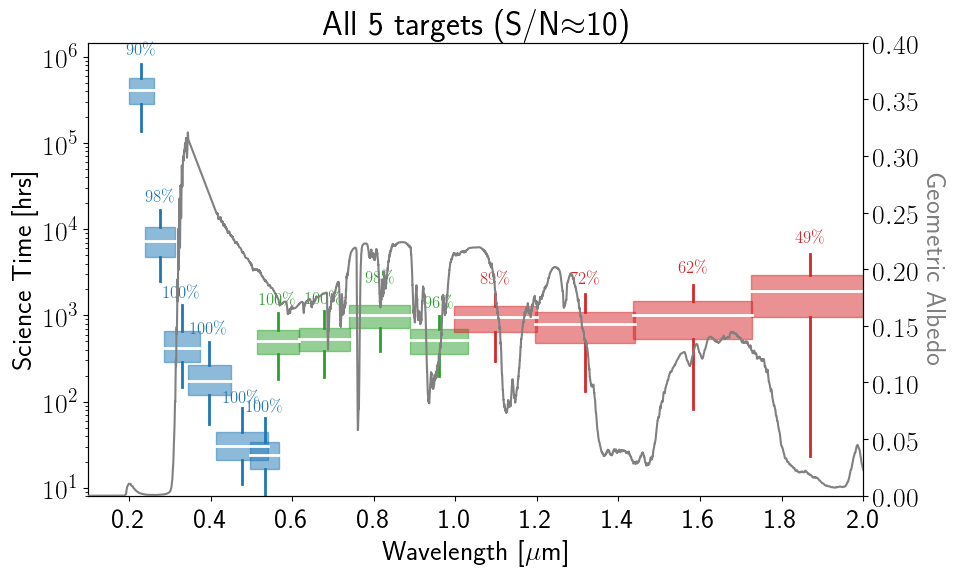

In [25]:
fig, ax2 = plt.subplots(figsize = (10,6))
cc = ["C0", "C2", "C3"]

ax = ax2.twinx()

ax.plot(lamhr, Ahr, c = "grey", zorder = 100)
ax.set_ylim(0.0, 0.1*np.ceil(10*np.max(Ahr[lamhr < 2.0])))
ax.set_ylabel("Geometric Albedo", rotation = 270, labelpad = 22, color = "grey")

# Transform quantities for boxplot
tmp = [np.zeros((len(tpbpcs_draws_tots[i]), Xdraw)) for i in range(len(spectroscopy.CHANNELS))]
for i in range(Xdraw):
    for j in range(len(tpbpcs_draws_tots)):
        for k in range(len(tpbpcs_draws_tots[j])):
            tmp[j][k,i] = tpbpcs_draws_tots[j][k][i]

icount = 0
for j in range(len(tmp)):
    
    data = []
    positions = []
    widths = []
    for i in range(tmp[j].shape[0]):
        data.append(tmp[j][i,:])
        positions.append(np.mean(specs[0][0][icount]))
        widths.append(specs[0][0][icount][-1] - specs[0][0][icount][0])
        
        comp_str = "$%i \%%$" %(100.*np.mean(comp_draws_stars[j][i]))
        ax2.text(positions[i], np.median(tmp[j][i,:]) + 5.*np.std(tmp[j][i,:]), comp_str, 
                 ha = "center", va = "top", fontsize = 12, color = cc[j])
        
        #ax.plot(specs[0][0][icount], specs[0][1][icount], ls = "steps-mid", color = "grey", zorder = 100)
        #ax.errorbar(specs[0][0][icount], specs[0][2][icount], yerr=specs[0][3][icount], fmt = "o", ms = 2.0, alpha = 0.7, color = "k")
        
        icount += 1
        
    color1 = cc[j]
    positions = np.array(positions)
    widths = np.array(widths)
    bp1 = ax2.boxplot(data, sym = '', widths = widths, showfliers = False, 
                      boxprops = {"color" : color1, "alpha" : 0.5}, 
                      whiskerprops = {"color" : color1, "linewidth" : 2.0}, 
                      capprops = {"color" : color1, "linewidth" : 0.0}, 
                      medianprops = {"color" : "w", "linewidth" : 2.0}, 
                      patch_artist=True, positions = positions, whis = [5, 95]); 

    for patch in bp1['boxes']:
        patch.set_facecolor(color1)
    
ax2.set_ylabel("Science Time [hrs]")
ax2.set_title(r"All %i targets (S/N$\approx$%i)" %(Ndraw, wantSNR))
ax2.set_yscale("log")

ax2.set_xlabel("Wavelength [$\mu$m]")
ax2.set_ylim(bottom = 0.0)

ax2.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
ax2.set_xticklabels([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
ax2.set_xlim(0.1, 2.0)

## Plot the exposure time and completeness in each band for randomly sampled stars

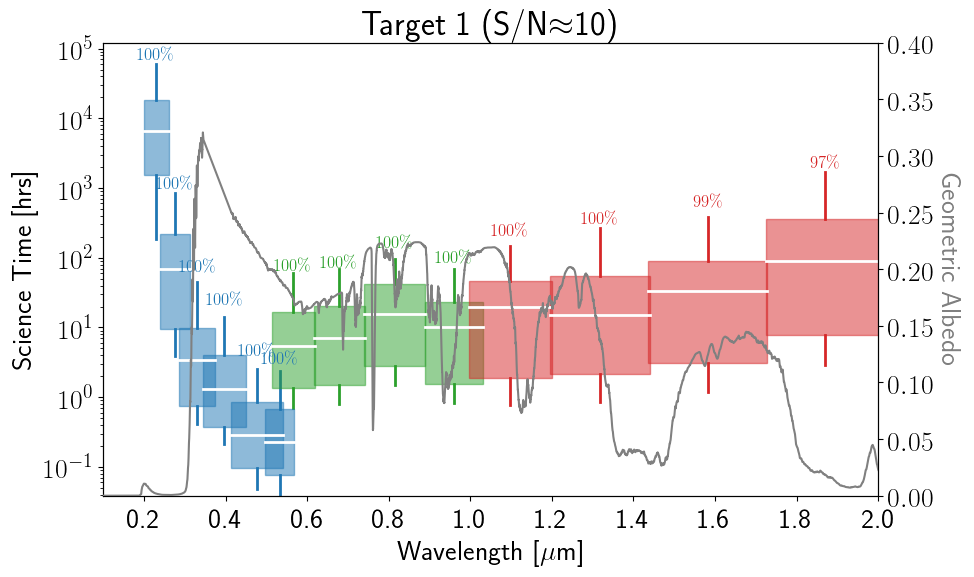

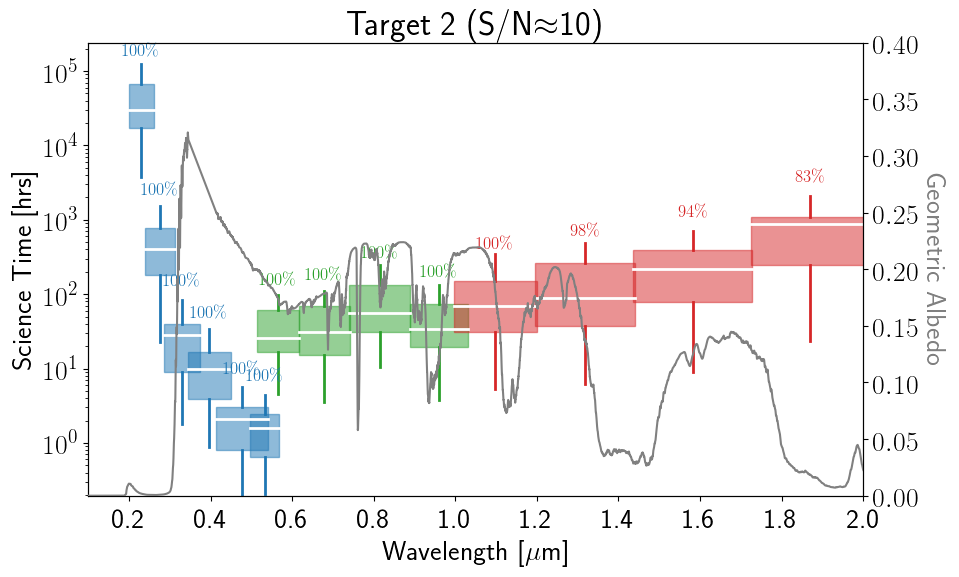

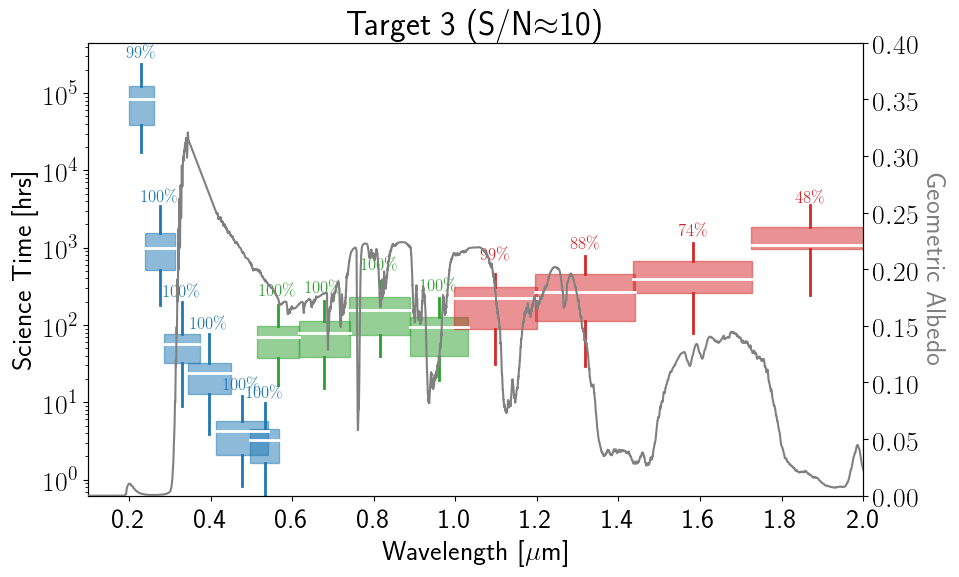

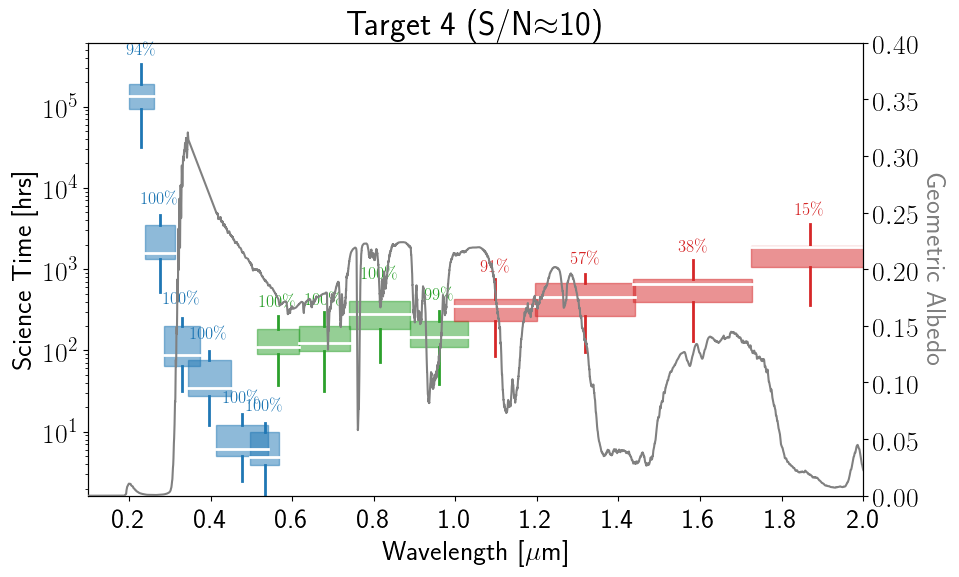

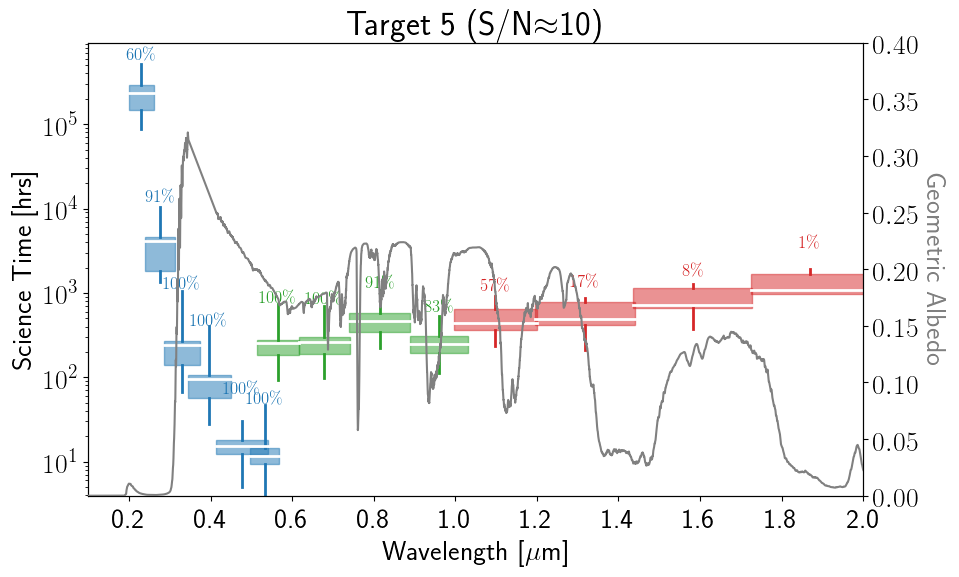

In [26]:
for itarget in range(Ndraw):
    
    fig, ax2 = plt.subplots(figsize = (10,6))
    cc = ["C0", "C2", "C3"]

    ax = ax2.twinx()

    ax.plot(lamhr, Ahr, c = "grey", zorder = 100)
    ax.set_ylim(0.0, 0.1*np.ceil(10*np.max(Ahr[lamhr < 2.0])))
    ax.set_ylabel("Geometric Albedo", rotation = 270, labelpad = 22, color = "grey")

    # Transform quantities for boxplot
    tmp = [np.zeros((len(tpbpcs_draws_stars[i]), Xdraw)) for i in range(len(spectroscopy.CHANNELS))]
    for i in range(Xdraw):
        for j in range(len(tpbpcs_draws_stars)):
            for k in range(len(tpbpcs_draws_stars[j])):
                tmp[j][k,i] = tpbpcs_draws_stars[j][k][itarget, i]

    icount = 0
    for j in range(len(tmp)):

        data = []
        positions = []
        widths = []
        for i in range(tmp[j].shape[0]):
            nans = np.isnan(tmp[j][i,:])
            data.append(tmp[j][i,~nans])
            positions.append(np.mean(specs[0][0][icount]))
            widths.append(specs[0][0][icount][-1] - specs[0][0][icount][0])

            comp_str = r"$%i \%%$" %(100.*comp_draws_stars[j][i][itarget])
            ax2.text(positions[i], np.nanmedian(tmp[j][i,:]) + 5.*np.nanstd(tmp[j][i,:]), comp_str, 
                     ha = "center", va = "top", fontsize = 12, color = cc[j])

            #ax.plot(specs[0][0][icount], specs[0][1][icount], ls = "steps-mid", color = "grey", zorder = 100)
            #ax.errorbar(specs[0][0][icount], specs[0][2][icount], yerr=specs[0][3][icount], fmt = "o", ms = 2.0, alpha = 0.7, color = "k")

            icount += 1

        color1 = cc[j]
        positions = np.array(positions)
        widths = np.array(widths)
        bp1 = ax2.boxplot(data, sym = '', widths = widths, showfliers = False, 
                          boxprops = {"color" : color1, "alpha" : 0.5}, 
                          whiskerprops = {"color" : color1, "linewidth" : 2.0}, 
                          capprops = {"color" : color1, "linewidth" : 0.0}, 
                          medianprops = {"color" : "w", "linewidth" : 2.0}, 
                          patch_artist=True, positions = positions, whis = [5, 95]); 

        for patch in bp1['boxes']:
            patch.set_facecolor(color1)

    ax2.set_ylabel("Science Time [hrs]")
    ax2.set_title(r"Target %i (S/N$\approx$%i)" %(itarget+1, wantSNR))
    ax2.set_yscale("log")

    ax2.set_xlabel("Wavelength [$\mu$m]")
    ax2.set_ylim(bottom = 0.0)

    ax2.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
    ax2.set_xticklabels([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
    ax2.set_xlim(0.1, 2.0)

## Make a Lookup Table of Exposure times for each star in sample

In [27]:
tpbpcs_rect = []    # Time per bandpass 
tpcs_rect = []      # Time per channel 

for idrew in range(NBIAS):
    
    tpbpcs_rect.append([])
    tpcs_rect.append([])
    bp_names = []

    for ichan in range(len(spectroscopy.CHANNELS)):
        
        tpcs_rect[idrew].append(0.0)

        for iband in range(len(tpbpcs[0][ichan])):
            
            bp_names.append("%s %i" %(spectroscopy.CHANNELS[ichan], iband+1))
            tpbpcs_rect[idrew].append(tpbpcs[idrew][ichan][iband])
            tpcs_rect[idrew][ichan] += tpbpcs[idrew][ichan][iband]
        
tpbpcs_rect = np.array(tpbpcs_rect)
tpcs_rect = np.array(tpcs_rect)
bp_names = np.array(bp_names)

# Make infs --> nans
infmask = ~np.isfinite(tpbpcs_rect)
tpbpcs_rect[infmask] = np.nan
infmask = ~np.isfinite(tpcs_rect)
tpcs_rect[infmask] = np.nan

In [28]:
data = np.vstack([biased_sample["hip"], 
                  biased_sample["stype"], 
                  biased_sample["dist"], 
                  tpbpcs_rect.T])
columns = np.hstack(["HIP", "type", "d [pc]", bp_names])

isort = np.argsort(tpbpcs_rect[:,6])

table = pd.DataFrame(data[:, isort].T, columns=columns)
table

,HIP,type,d [pc],UV 1,UV 2,UV 3,UV 4,UV 5,UV 6,vis 1,vis 2,vis 3,vis 4,NIR 1,NIR 2,NIR 3,NIR 4
0,91772,K5,3.49174,187.2315596589601,3.9125439227349506,0.4151487381023866,0.21290717649682112,0.04905616543756699,0.038695311755568604,0.7085234323583146,0.8102721809411598,1.4733578604415354,0.8298805622489448,0.7723102225455132,0.8653010852314148,1.1852605587334684,2.8944880300568814
1,85523,K5,4.5405,502.53298168304343,8.229368079165365,0.7442487043531214,0.3734548354103989,0.08487523447249927,0.06697701314728523,1.2887031228679129,1.4865215084123453,2.7852276643267664,1.5657733521708903,1.8874858928272789,2.1733370928809097,3.0798295134585914,7.884922044409984
2,85523,K5,4.5405,502.53298168304343,8.229368079165365,0.7442487043531214,0.3734548354103989,0.08487523447249927,0.06697701314728523,1.2887031228679129,1.4865215084123453,2.7852276643267664,1.5657733521708903,1.8874858928272789,2.1733370928809097,3.0798295134585914,7.884922044409984
3,8102,G8V,3.65017,nan,9.449373961882703,0.9189730336588516,0.4669177380743684,0.09743417982011032,0.07706563882605907,1.3462236975491686,1.4829622621735639,2.5404319326764178,1.3664652953312346,1.050247660703232,1.1243352938554794,1.4783465043171276,3.505545320361731
4,99461,K2V,6.01504,1538.229588144451,22.930246838380544,1.7871885309161473,0.8934945387814253,0.19502274690982763,0.15480313897663436,3.1046940239776033,3.584122413651052,6.775464256937796,3.7226383674147687,5.343847717805415,6.2013057462203225,8.91199654692461,23.464498170141713
5,12114,K3V,7.1803,3002.439292387611,37.80935912560754,2.5124312899263694,1.2097453690600863,0.2616067513587022,0.20740303937437968,4.494250040021261,5.260260767710266,10.37967092126021,5.724438389619316,10.149993377172452,11.978140444668806,17.51721285948453,nan
6,113283,K4Vp,7.60919,3742.1073929337026,44.496410069721286,2.769619392869843,1.3105396721341098,0.28314532816246046,0.22451727876766708,5.052591780920745,5.976730594593092,12.061864773550294,6.712062798232568,12.629242364730693,14.991876496757824,nan,nan
7,84720,M0V,8.80204,6567.585787778452,68.7696687110114,3.4437143907754226,1.4405578113153454,0.29146597499117977,0.22600674564559567,5.901095180807356,7.001820716855124,15.365936963055026,nan,nan,nan,nan,nan
8,32984,K3V,8.71004,6393.392701968027,72.84814874737629,4.15688272808973,1.9309177609120145,0.4073710237657843,0.32327000807384565,7.605560927770316,9.00603469535458,18.414772208815908,10.127944327529221,21.08558931990689,25.111408886422893,nan,nan
9,57939,G8Vp,9.09174,8133.784632732586,113.0374434119645,7.2351917670827435,3.427887606249426,0.6869830372996382,0.5445242437242673,11.593913342688897,13.240237017511284,25.448171457917695,13.508608928582886,25.417423107336766,29.85951914904481,43.68369848262883,nan


## How many stars can we get complete spectra for in a specified amount of observing time?

In [29]:
def count_star_wantexp(wantexp = 365. * 24., Ndraw = 5, Xdraw = 500):
    """
    Determine the number of stars that can be observed in a given exposure time. 
    
    Parameters
    ----------
    wantexp : float
        Total exposure time [hours]
    """
    
    ichan = 1
    iband = 0
    
    Ns = np.zeros(Xdraw)
    texps = np.zeros(Xdraw)
    
    for ix in range(Xdraw):
        
        # Randomly draw sample indices
        idraw = np.random.choice(np.arange(NBIAS), size=Ndraw, replace=False)

        # Get exptimes for each star drawn
        tmp_draws = np.array([t_tots_N[0,idrew] for idrew in idraw])

        # Sort by exposure time (to break a labeling degeneracy and express uniqueness and priority)
        isort = np.argsort(tmp_draws)
        
        tmp_draws = tmp_draws[isort]
        
        texp = 0.0
        iN = 0
        
        while ((texp+tmp_draws[iN]) < wantexp) and (iN < Ndraw):
            
            texp += tmp_draws[iN]
            iN += 1
            
        Ns[ix] = iN
        texps[ix] = texp
    
    return Ns, texps

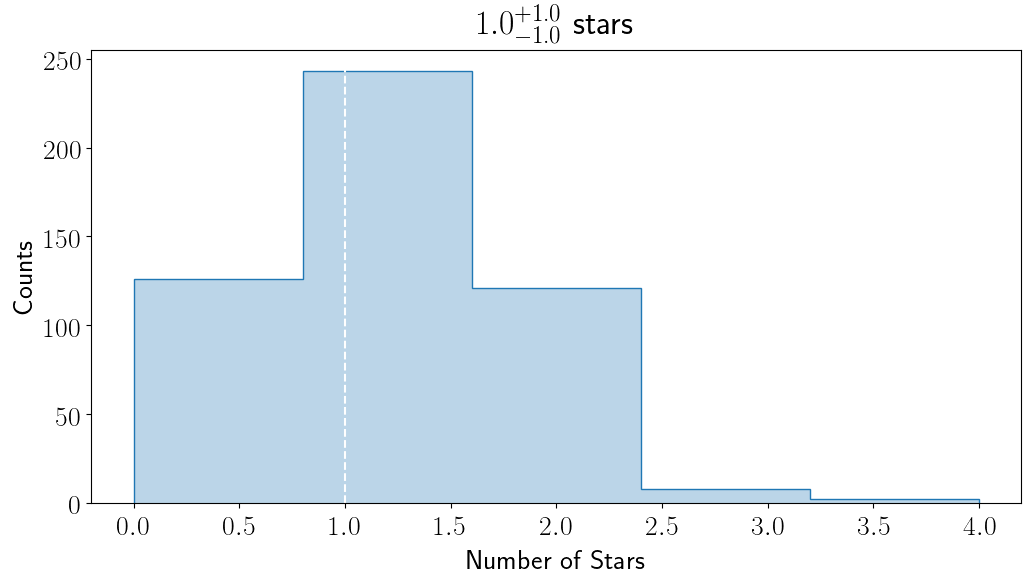

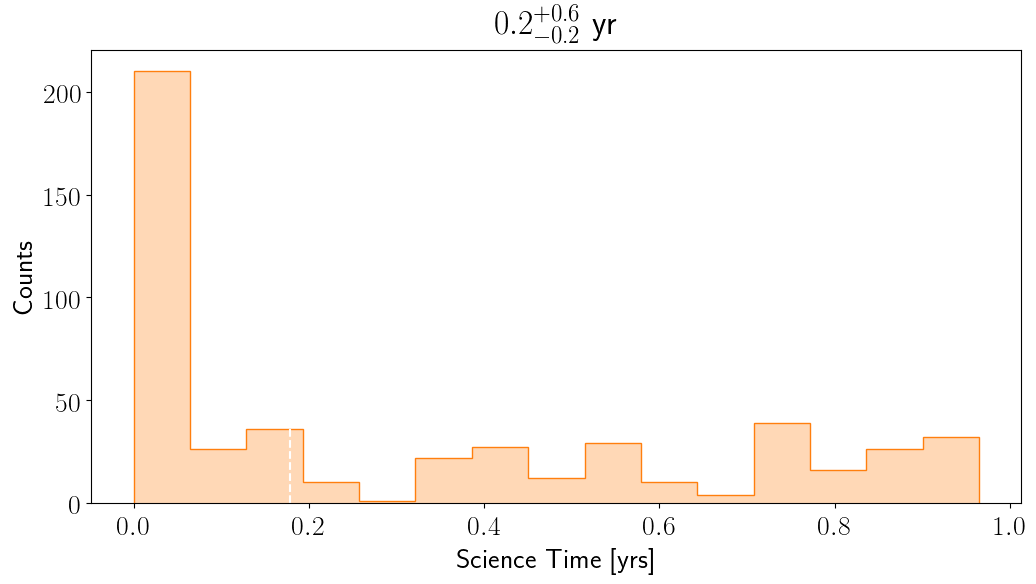

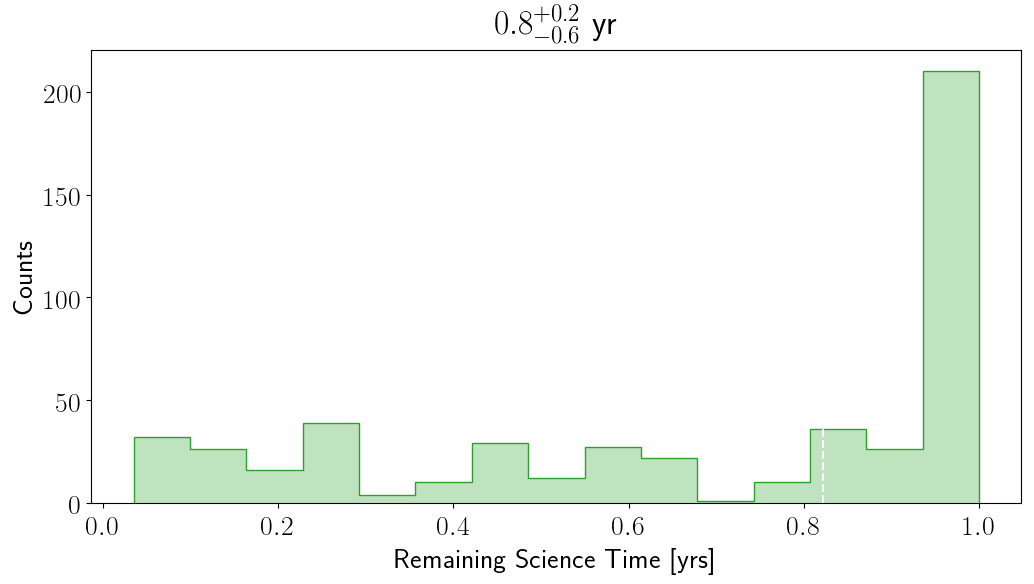

In [30]:
wantexp_yr = 1.0
wantexp_hr = 365. * 24. * wantexp_yr

num_stars, texps = count_star_wantexp(wantexp = wantexp_hr)

texps_yr = texps / (365. * 24.)

# Plot exposure time hist
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(num_stars)
result = "$%.1f^{+%.1f}_{-%.1f}$ stars" %(q_50, q_p, q_m)
fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlabel("Number of Stars")
ax.set_ylabel("Counts")
ax.set_title(result)
ax.hist(num_stars, bins = 5, alpha = .3, color = "C0");
ax.hist(num_stars, bins = 5, alpha = 1.0, histtype="step", color = "C0");
ax.axvline(q_50, color = "w", ls = "dashed")

# Plot exposure time hist
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(texps_yr)
result = "$%.1f^{+%.1f}_{-%.1f}$ yr" %(q_50, q_p, q_m)
fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlabel("Science Time [yrs]")
ax.set_ylabel("Counts")
ax.set_title(result)
ax.hist(texps_yr, bins = 15, alpha = .3, color = "C1");
ax.hist(texps_yr, bins = 15, alpha = 1.0, histtype="step", color = "C1");
ax.axvline(q_50, color = "w", ls = "dashed")

# Plot exposure time hist
texps_yr_remain = wantexp_yr - texps_yr
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(texps_yr_remain)
result = "$%.1f^{+%.1f}_{-%.1f}$ yr" %(q_50, q_p, q_m)
fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlabel("Remaining Science Time [yrs]")
ax.set_ylabel("Counts")
ax.set_title(result)
ax.hist(texps_yr_remain, bins = 15, alpha = .3, color = "C2");
ax.hist(texps_yr_remain, bins = 15, alpha = 1.0, histtype="step", color = "C2");
ax.axvline(q_50, color = "w", ls = "dashed")

In [31]:
Xdraw = 500
eta_interesting = np.linspace(0.1, 1.0, 100)
ns_eta = np.zeros((len(eta_interesting), Xdraw))
texps_eta = np.zeros((len(eta_interesting), Xdraw))

for i, e_i in enumerate(eta_interesting):

    Nd = int(np.floor(e_i * NBIAS))
    
    ns_eta[i,:], texps_eta[i,:] = count_star_wantexp(wantexp = wantexp_hr, Ndraw = Nd, Xdraw = Xdraw)

(0.0, 8.35)

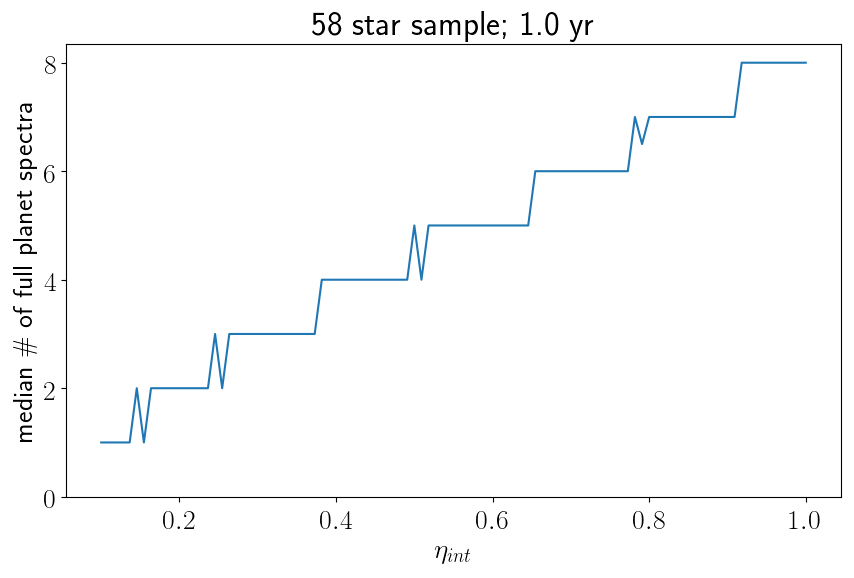

In [32]:
fig, ax = plt.subplots(figsize = (10,6))
ax.set_xlabel("$\eta_{int}$")
ax.set_ylabel("median \# of full planet spectra")
ax.set_title("%i star sample; %.1f yr" %(NBIAS, wantexp_yr))
#ax.errorbar(eta_interesting, np.median(ns_eta, axis = 1), yerr=np.std(ns_eta, axis = 1))
ax.plot(eta_interesting, np.median(ns_eta, axis = 1))
ax.set_ylim(bottom=0.0)

/Users/Jake/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


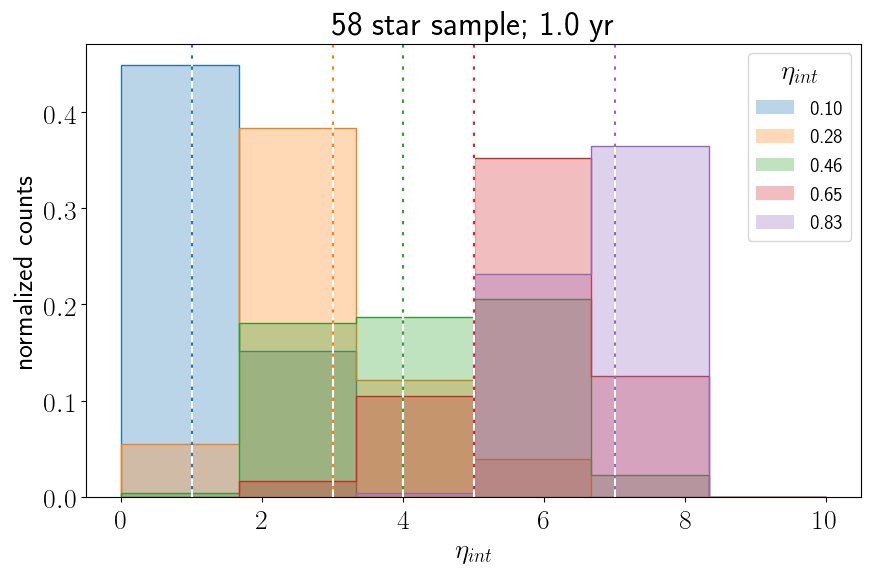

In [33]:
fig, ax = plt.subplots(figsize = (10,6))
ax.set_xlabel("$\eta_{int}$")
ax.set_ylabel("normalized counts")
#ax.set_ylabel("median \# of full planet spectra")
ax.set_title("%i star sample; %.1f yr" %(NBIAS, wantexp_yr))

xrange = (0, 10)

ic = 0
for i in range(0,ns_eta.shape[0])[::20]:
    c = "C%i" %ic
    ax.hist(ns_eta[i,:], bins = 6, alpha = .3, color = c, label = "%0.2f" %eta_interesting[i], normed=True, range = xrange);
    ax.hist(ns_eta[i,:], bins = 6, alpha = 1.0, histtype="step", color = c, normed=True, range = xrange);
    ax.axvline(np.median(ns_eta[i,:]), color = c)
    ax.axvline(np.median(ns_eta[i,:]), color = "w", ls = "dashed")
    ic += 1
    
ax.legend(title = "$\eta_{int}$", fontsize = 14, ncol = 1)

# Detect Individual Molecular Bands

## Reproduce Feng et al. (2018) SNR scaling relationship

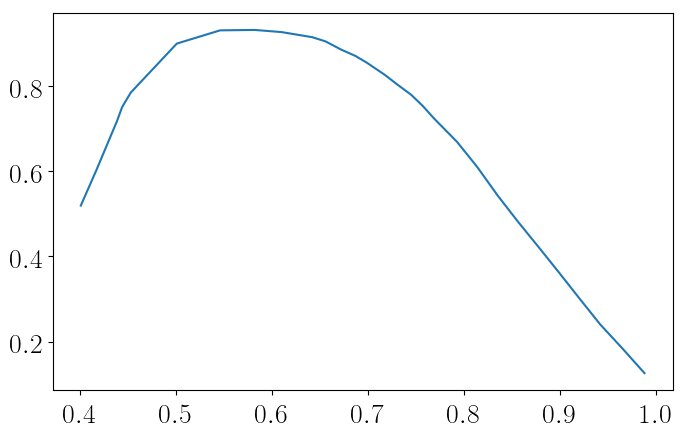

In [34]:
qe_data = np.genfromtxt("../inputs/QE_Feng_2018.txt", skip_header=1)
lam_qe = qe_data[:,0]
qe_lam = qe_data[:,1]

plt.plot(lam_qe, qe_lam)

In [35]:
luvoir_feng = spectroscopy.default_luvoir()

luvoir_feng.lammin = 0.4
luvoir_feng.lammax = 1.0

luvoir_feng.qe = 0.0185
luvoir_feng.qe_lam = (lam_qe, qe_lam)

cn.telescope = luvoir_feng

cn.star.Rs = 1.0
cn.star.Teff = 5780.

cn.planet.distance = 5.0
cn.planet.a = 1.0

# Run count rates (necessary to generate new wavelength grid)
cn.run_count_rates(spectroscopy.AHR, spectroscopy.LAMHR, spectroscopy.FSTAR)

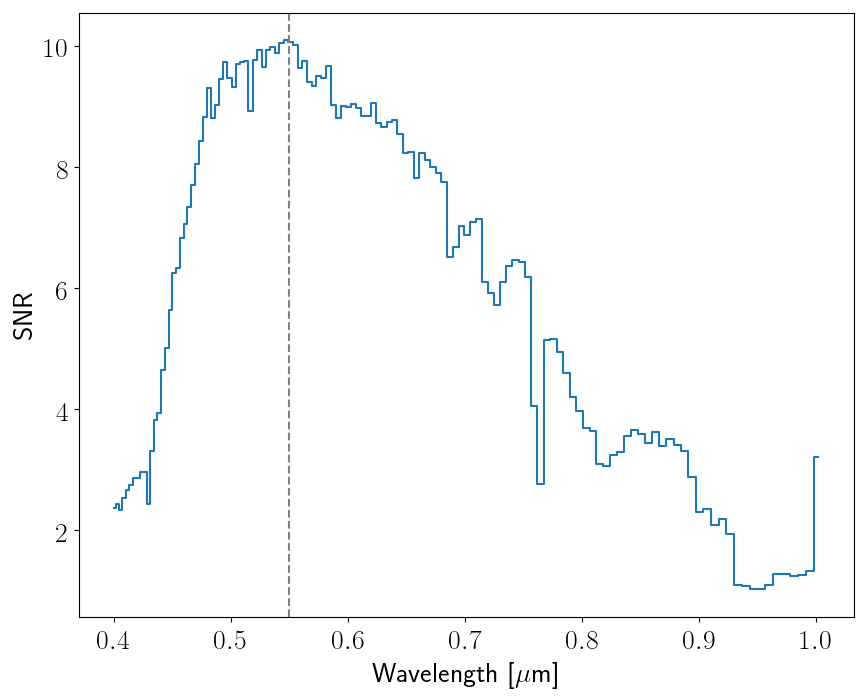

In [36]:
i550 = np.argmin(np.fabs(cn.lam - 0.550))

snr_feng = cn.SNRt #/ cn.SNRt[i550]

fig, ax = plt.subplots(figsize = (10,8))
ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("SNR")
ax.plot(cn.lam, snr_feng, ls = "steps-mid")
ax.axvline(0.550, c = "gray", ls = "dashed")

SNR_O2A = SNR_550nm * 0.230


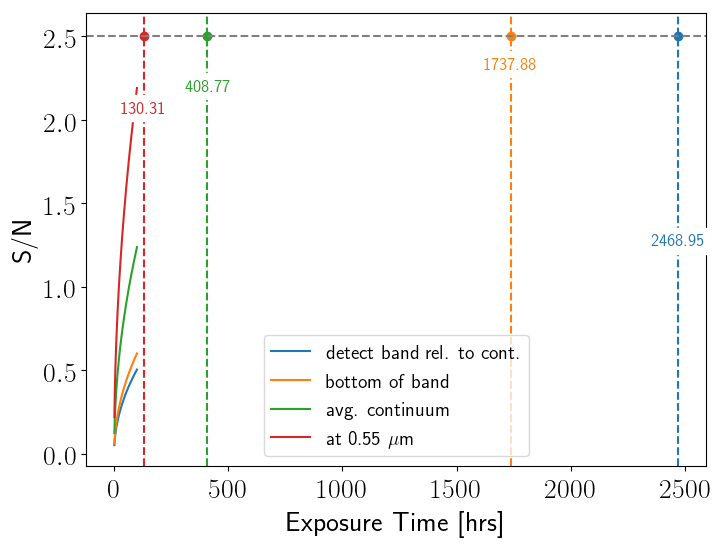

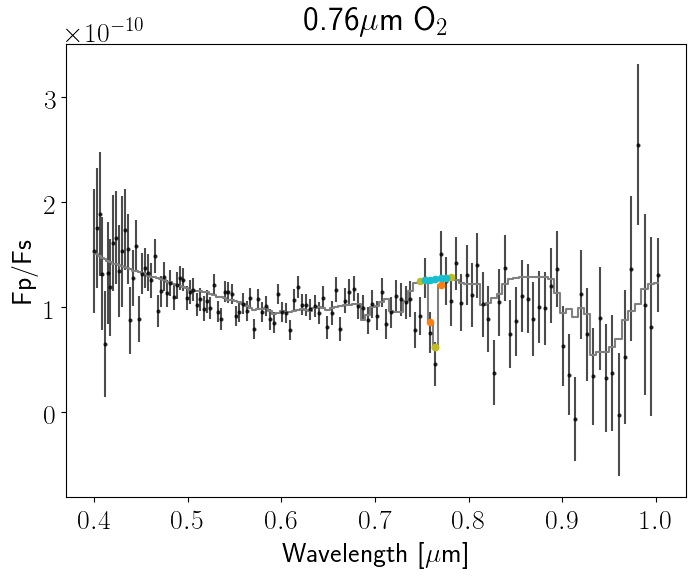

In [37]:
etimes = spectroscopy.determine_exposure_time(cn, [0.75, 0.78], title = "0.76$\mu$m O$_2$", 
                                 plot_snr_curves=True, plot_spectrum=True, wantSNR=2.5)

rat_snr_o2a = np.sqrt(etimes[3] / etimes[0])

print("SNR_O2A = SNR_550nm * %.3f" %(rat_snr_o2a))

### Test additional molecular bands

SNR_H2O = SNR_550nm * 0.136
SNR_H2O = SNR_550nm * 0.159
SNR_H2O = SNR_550nm * 0.237
SNR_H2O = SNR_550nm * 0.284


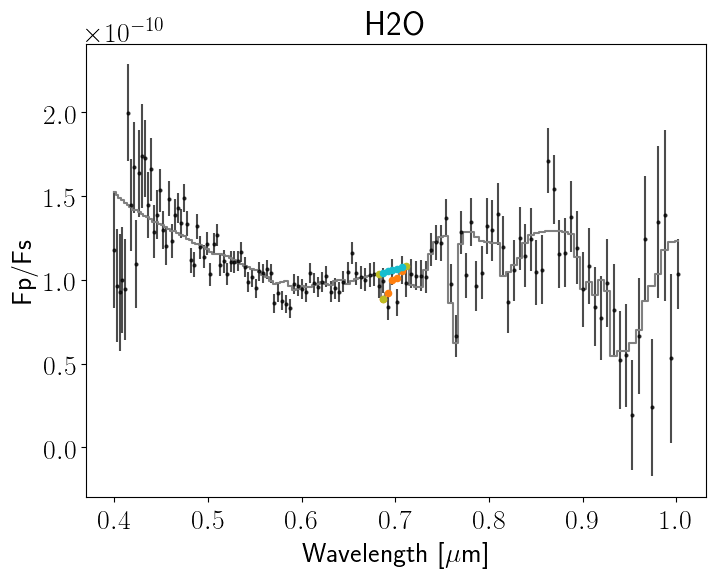

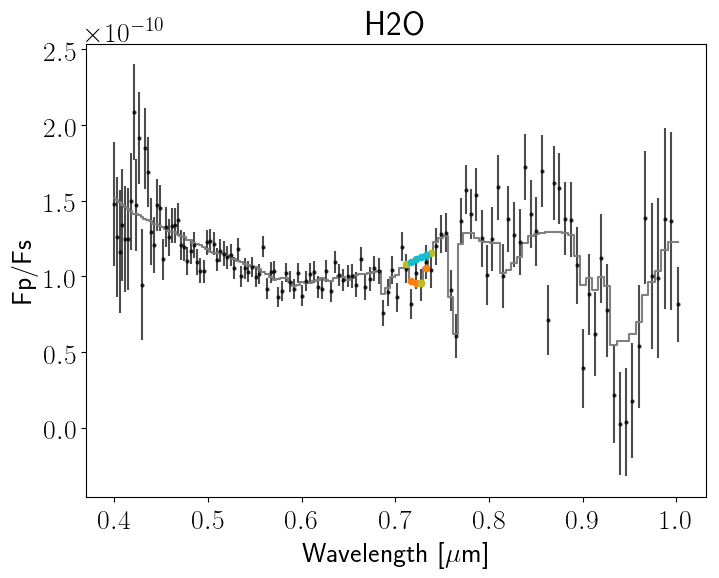

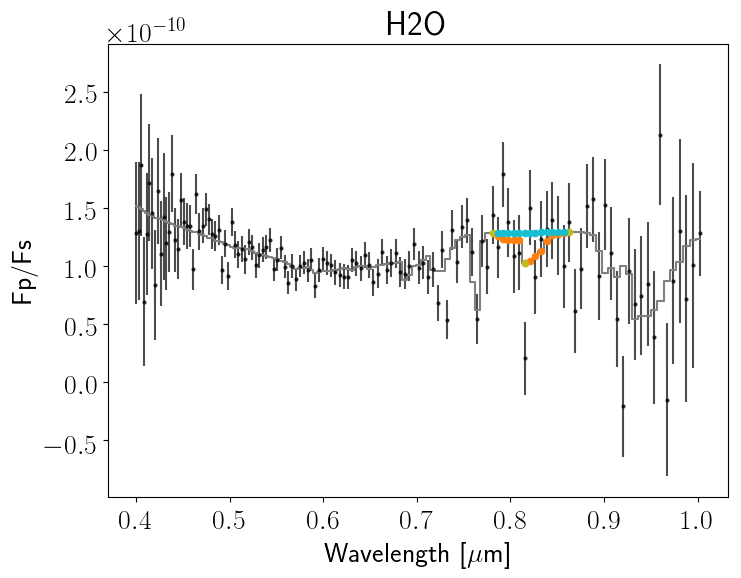

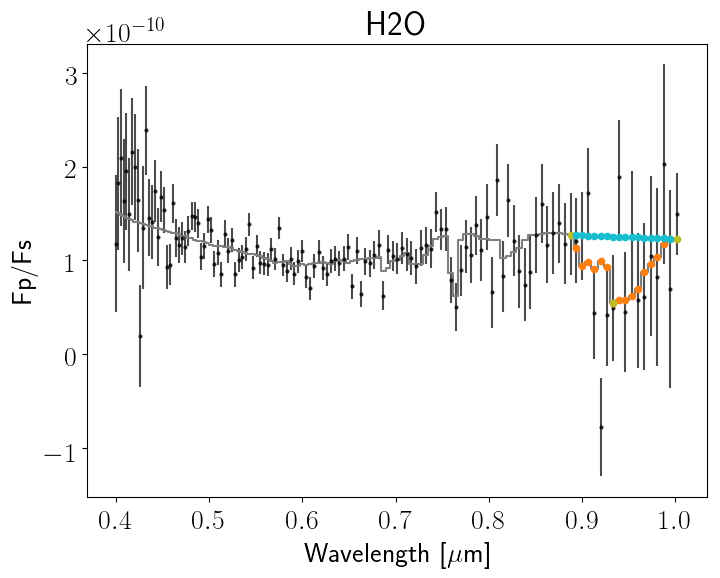

In [38]:
etimes = spectroscopy.determine_exposure_time(cn, [0.68, 0.71], title = "H2O", 
                                 plot_snr_curves=False, plot_spectrum=True, wantSNR=2.5)

rat_snr_h2o = np.sqrt(etimes[3] / etimes[0])

print("SNR_H2O = SNR_550nm * %.3f" %(rat_snr_h2o))


etimes = spectroscopy.determine_exposure_time(cn, [0.71, 0.74], title = "H2O", 
                                 plot_snr_curves=False, plot_spectrum=True, wantSNR=2.5)

rat_snr_h2o = np.sqrt(etimes[3] / etimes[0])

print("SNR_H2O = SNR_550nm * %.3f" %(rat_snr_h2o))


etimes = spectroscopy.determine_exposure_time(cn, [0.78, 0.86], title = "H2O", 
                                 plot_snr_curves=False, plot_spectrum=True, wantSNR=2.5)

rat_snr_h2o = np.sqrt(etimes[3] / etimes[0])

print("SNR_H2O = SNR_550nm * %.3f" %(rat_snr_h2o))


etimes = spectroscopy.determine_exposure_time(cn, [0.89, 1.0], title = "H2O", 
                                 plot_snr_curves=False, plot_spectrum=True, wantSNR=2.5)

rat_snr_h2o = np.sqrt(etimes[3] / etimes[0])

print("SNR_H2O = SNR_550nm * %.3f" %(rat_snr_h2o))

SNR_O3 = SNR_550nm * 0.110


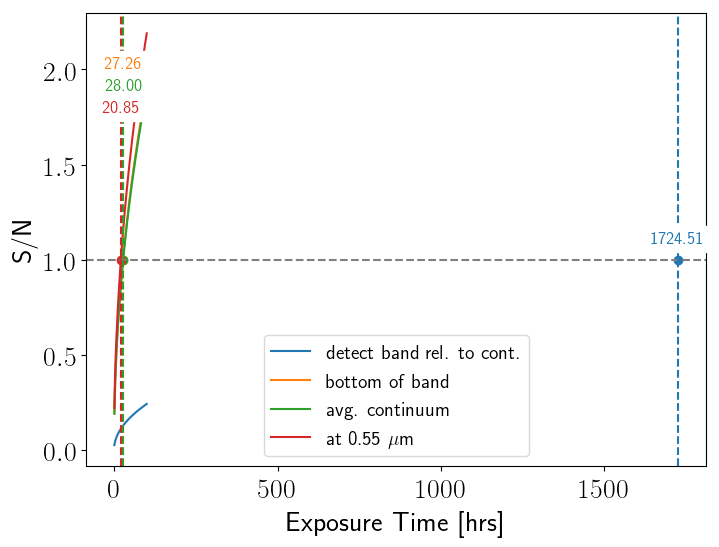

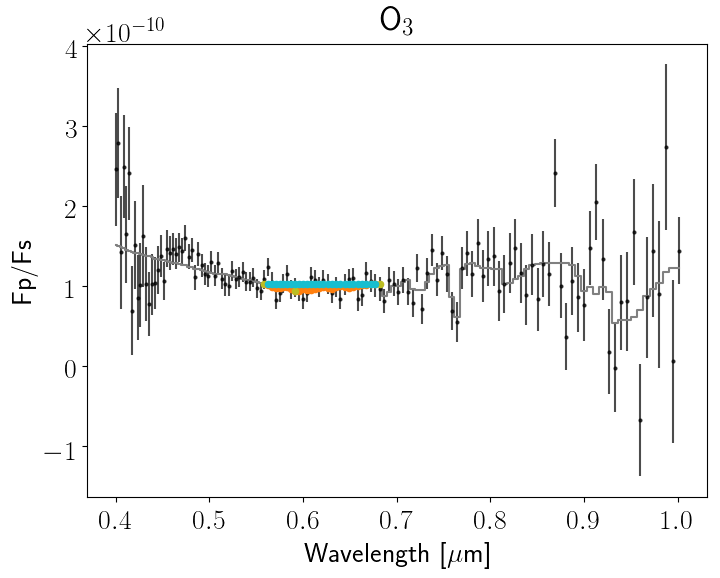

In [39]:
# vis
#cn.telescope = spectroscopy.default_luvoir(channel="vis", architecture="A")

# Run count rates (necessary to generate new wavelength grid)
#cn.run_count_rates(spectroscopy.AHR, spectroscopy.LAMHR, spectroscopy.FSTAR)

# O3
etimes_O3 = spectroscopy.determine_exposure_time(cn, [0.56, 0.68], title = "O$_3$", 
                             plot_snr_curves=True, plot_spectrum=True, wantSNR=1.)

rat_snr_o3 = np.sqrt(etimes_O3[3] / etimes_O3[0])

print("SNR_O3 = SNR_550nm * %.3f" %(rat_snr_o3))

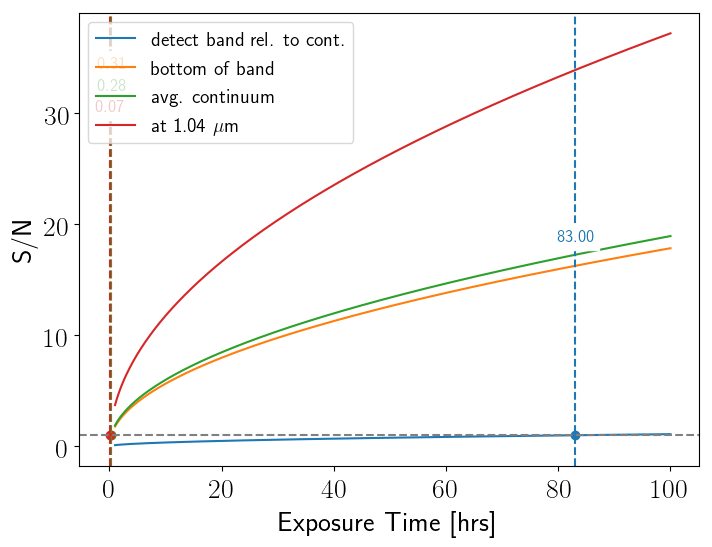

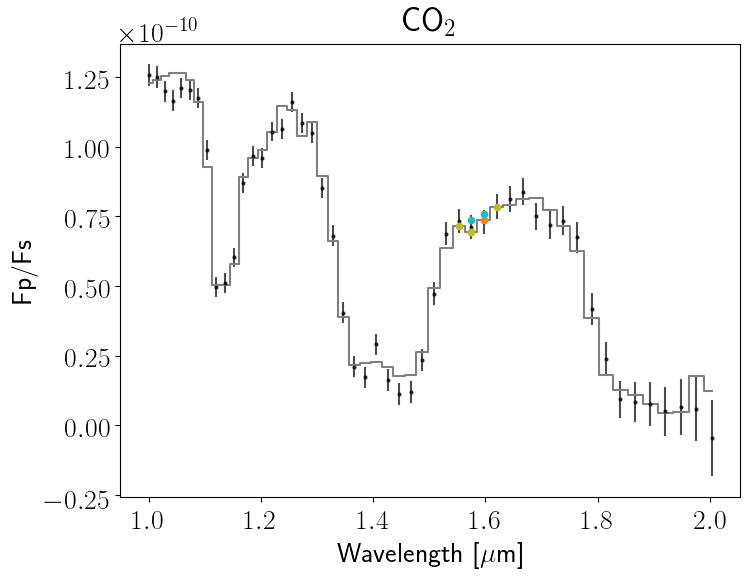

In [40]:
# NIR
cn.telescope = spectroscopy.default_luvoir(channel="NIR", architecture="A")
cn.telescope.resolution = 70.

# Run count rates (necessary to generate new wavelength grid)
cn.run_count_rates(spectroscopy.AHR, spectroscopy.LAMHR, spectroscopy.FSTAR)

# CO2
etimes_CO2 = spectroscopy.determine_exposure_time(cn, [1.55, 1.63], title = "CO$_2$", 
                             plot_snr_curves=True, plot_spectrum=True, wantSNR=1.,
                             ref_lam = 1.05)

## Calculate time to detect molecular bands for each star in sample

In [41]:
molecule_list = ["O2", "O3", "CO2", "H2O"]

molecule_bands = {
    "O2"   : ( [0.75, 0.78], ), 
    "O3"   : ( [0.56, 0.68], ), 
    "CO2"  : ( [1.55, 1.63], ),
    "H2O"  : ( [0.68, 0.71], [0.71, 0.74], [0.78, 0.86], [0.89, 1.0])
}

def get_mband_channel(bandlims, architecture="A"):
    """
    Get the LUVOIR channel name for a given bandwidth, ``bandlims``
    """
    
    for chan in spectroscopy.CHANNELS:
        
        ts = spectroscopy.default_luvoir(channel=chan, architecture=architecture)
        
        if (bandlims[0] >= ts.lammin) and (bandlims[1] <= ts.lammax):
            
            return chan
        
    return None

def total_molec_bands(mol_dict):
    """
    """
    k = 0
    # Loop over each molecular band
    for molec in mol_dict.keys():
        for band in mol_dict[molec]: 
            k += 1
    return k

def get_mband_names():
    names = []
    # Loop over each molecular band
    for molec in molecule_list:
        for i, band in enumerate(molecule_bands[molec]): 
            names.append(molec + "_%i" %(i+1))
    return names

In [42]:
print(get_mband_channel(molecule_bands["O2"][0]))
print(total_molec_bands(molecule_bands))
print(get_mband_names())

vis
7
['O2_1', 'O3_1', 'CO2_1', 'H2O_1', 'H2O_2', 'H2O_3', 'H2O_4']


In [43]:
wantSNR = 10.0
architecture = "A"

# Perform calculation for all stars in biased sample
biased_sample = spectroscopy.read_luvoir_stars()
Ndraw = len(biased_sample["dist"])
Nbands = total_molec_bands(molecule_bands) 

np.random.seed(seed=None)

# Allocate memory for exposure times
tpmbs = np.zeros((Ndraw, Nbands, 4))
t_o2a = []#np.zeros(Ndraw)
t_co2 = []
t_o3 = []
t_h2o_1 = []
t_h2o_2 = []
t_h2o_3 = []
t_h2o_4 = []
#tpbpcs = []
#pct_obs_iwas = []
#lammax_obs_iwas = []
#specs = []

# Loop over stars in this sample
for i in range(Ndraw):
    
    #print("HIP %i, %.2f pc, %s " %(hip[i], dist[i], stype[i]))

    # Set system parameters for this star
    cn = spectroscopy.prep_ith_star(cn, i)
    
    k = 0
    # Loop over each molecular band
    for molec in molecule_list:
        for band in molecule_bands[molec]: 
        
            # Get the right LUVOIR channel for this band
            chan = get_mband_channel(band, architecture=architecture)
    
            # Set telescope model
            cn.telescope = spectroscopy.default_luvoir(channel=chan, architecture=architecture)
            
            # Run count rates (necessary to generate new wavelength grid)
            cn.run_count_rates(spectroscopy.AHR, spectroscopy.LAMHR, spectroscopy.FSTAR)
    
            # Get exposure times
            etimes = spectroscopy.determine_exposure_time(cn, band, title = molec, wantSNR=wantSNR,
                                         plot_snr_curves=False, plot_spectrum=False)
            
            # Save band detection
            tpmbs[i,k,:] = np.array(etimes)
            
            k += 1
            
# etime_band, etime_bot, etime_cont, etime_fid

In [44]:
data2 = np.vstack([biased_sample["hip"], 
                  biased_sample["stype"], 
                  biased_sample["dist"], 
                  tpmbs[:,0,0], 
                  tpmbs[:,1,0], 
                  tpmbs[:,2,0], 
                  tpmbs[:,3,0], 
                  tpmbs[:,4,0], 
                  tpmbs[:,5,0], 
                  tpmbs[:,6,0]])
columns = np.hstack(["HIP", "type", "d [pc]", "O2 0.76", "O3 0.6", "CO2 1.6", "H2O 0.7", "H2O 0.73", "H2O 0.83", "H2O 0.94"])

isort = np.argsort(tpmbs[:,0,0])

table2 = pd.DataFrame(data2[:, isort].T, columns=columns)
table2.head(n = 10)

,HIP,type,d [pc],O2 0.76,O3 0.6,CO2 1.6,H2O 0.7,H2O 0.73,H2O 0.83,H2O 0.94
0,91772,K5,3.49174,13.717217288667667,416.2300908241331,2145.8638035043627,88.6771152808376,62.627599929630435,7.3103674314117795,1.5361458993345802
1,8102,G8V,3.65017,23.58418296245047,764.0742201646812,2686.1216912488044,158.73856679556,109.73808803574765,11.890805788849024,2.5144677143010914
2,85523,K5,4.5405,26.351965740644978,762.9282034457798,5620.375650796729,165.70289836085462,117.99462306814478,14.156749658960337,3.0179089717046117
3,85523,K5,4.5405,26.351965740644978,762.9282034457798,5620.375650796729,165.70289836085462,117.99462306814478,14.156749658960337,3.0179089717046117
4,99461,K2V,6.01504,65.06891930808833,1833.8340574935048,16360.352220726654,403.6708823896194,287.64796975188784,34.53293651634577,7.466563487521404
5,12114,K3V,7.1803,101.57330058360769,2692.541396980845,32233.32886550345,607.908404899913,438.64822348420535,54.84493420929463,11.98461042162197
6,113283,K4Vp,7.60919,118.54207974619565,3052.08052965672,nan,698.176917254213,506.8031612598402,64.50827417173039,14.229752972443926
7,84720,M0V,8.80204,155.8894056587315,3632.3918525117647,nan,861.4983645543941,640.4244541042834,nan,nan
8,32984,K3V,8.71004,183.2896097888821,4605.838923181823,nan,1064.767867363788,775.6817833282655,99.84490042454075,22.06876935645905
9,57939,G8Vp,9.09174,251.7175072707725,6814.509555523999,80576.61904450606,1523.4516711769015,1089.9238083196688,132.8786668914717,28.952779581971118


In [45]:
plt.plot(t_h2o_3[:,0] /  t_h2o_4[:,0], "o")
print("It's always more expensive to detect H2O at 0.8 um than 0.94")

TypeError: list indices must be integers, not tuple

In [46]:
print("------------------------------------")
for i in range(tpmbs.shape[1]):
    print(get_mband_names()[i])
    print("SNR_band = %.2f * SNR_continuum" %(np.nanmedian(np.sqrt(tpmbs[:,i,2] / tpmbs[:,i,0]))))
    #print("SNR_band = %.2f * SNR_fiducial" %(np.nanmedian(np.sqrt(tpmbs[:,i,3] / tpmbs[:,i,0]))))

------------------------------------
O2_1
SNR_band = 0.46 * SNR_continuum
O3_1
SNR_band = 0.08 * SNR_continuum
CO2_1
SNR_band = 0.06 * SNR_continuum
H2O_1
SNR_band = 0.18 * SNR_continuum
H2O_2
SNR_band = 0.22 * SNR_continuum
H2O_3
SNR_band = 0.65 * SNR_continuum
H2O_4
SNR_band = 1.18 * SNR_continuum


In [47]:
def run_hec_drm(Ndraw = 5, wantexp = None, verbose = True):
    """
    """
    
    iremove = 0
    
    # Randomly draw stellar sample indices
    idraw = np.random.choice(np.arange(NBIAS), size=Ndraw, replace=False)
    
    # Get exptimes for each star drawn
    tmp_draws = np.array([t_tots_N[iremove,idrew] for idrew in idraw])

    # Sort by exposure time (to break a labeling degeneracy and express uniqueness and priority)
    #isort = np.argsort(tmp_draws)

    #tmp_draws = tmp_draws[isort]
    
    for i in range(len(tmp_draws)): 
        print("HIP%s - %s - %.2fpc" %(biased_sample["hip"][idraw[i]], biased_sample["stype"][idraw[i]], biased_sample["dist"][idraw[i]]))
        print("    - Complete Spectrum : %.2f days" %(tmp_draws[i] / 24.))
        print("    - UV Spectrum : %.2f days" %(tpcs_rect[idraw[i],0] / 24.))
        print("    - Optical Spectrum : %.2f days" %(tpcs_rect[idraw[i],1] / 24.))
        print("    - NIR Spectrum : %.2f days" %(tpcs_rect[idraw[i],2] / 24.))
        print("    - O2 0.76 um : %.2f days" %(tpmbs[idraw[i],0,0] / 24.))
        print("    - O3 0.6 um : %.2f days" %(tpmbs[idraw[i],1,0] / 24.))
     
    print("---------------------FINAL TALLY---------------------")
    print("%.2f yrs for %i target's complete spectra (SNR=5)" %(np.sum(tmp_draws) / (24. * 356.), Ndraw))
    print("%.2f yrs for %i target's UV spectra (SNR=5)" %(np.sum(tpcs_rect[idraw,0]) / (24. * 356.), Ndraw))
    print("%.2f yrs for %i target's optical spectra (SNR=5)" %(np.sum(tpcs_rect[idraw,1]) / (24. * 356.), Ndraw))
    print("%.2f yrs for %i target's NIR spectra (SNR=5)" %(np.sum(tpcs_rect[idraw,2]) / (24. * 356.), Ndraw))
    print("%.2f yrs for %i target's O2 at 0.76 um (SNR=5)" %(np.sum(tpmbs[idraw,0,0]) / (24. * 356.), Ndraw))
    print("%.2f yrs for %i target's O3 at 0.6 um (SNR=5)" %(np.sum(tpmbs[idraw,1,0]) / (24. * 356.), Ndraw))

In [48]:
run_hec_drm()

HIP48113 - G2V - 18.37pc
    - Complete Spectrum : 5736.67 days
    - UV Spectrum : 5736.67 days
    - Optical Spectrum : 27.61 days
    - NIR Spectrum : nan days
    - O2 0.76 um : 118.58 days
    - O3 0.6 um : 2923.65 days
HIP43726 - G3V - 17.39pc
    - Complete Spectrum : 4567.61 days
    - UV Spectrum : 4567.61 days
    - Optical Spectrum : 22.84 days
    - NIR Spectrum : nan days
    - O2 0.76 um : 97.48 days
    - O3 0.6 um : 2409.68 days
HIP47080 - G8IV-V - 11.37pc
    - Complete Spectrum : 46.01 days
    - UV Spectrum : nan days
    - Optical Spectrum : 19.80 days
    - NIR Spectrum : 26.21 days
    - O2 0.76 um : 70.16 days
    - O3 0.6 um : 2143.88 days
HIP23693 - F7V - 11.65pc
    - Complete Spectrum : 1750.56 days
    - UV Spectrum : 1750.56 days
    - Optical Spectrum : 9.89 days
    - NIR Spectrum : 24.27 days
    - O2 0.76 um : 36.75 days
    - O3 0.6 um : 1171.34 days
HIP15371 - G1V - 12.03pc
    - Complete Spectrum : 1274.56 days
    - UV Spectrum : 1274.56 days
    - 

In [ ]:
start = datetime.datetime.now()

In [ ]:
finish = datetime.datetime.now()

In [ ]:
runtime = finish - start